# 1. Import Libraries

In [ ]:
### Import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, r2_score, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Load Dataset and Clean

In [ ]:
plt.close('all')

pd.set_option('future.no_silent_downcasting', True)
# 2.1. Loading the Data
df = pd.read_csv('survey_178.csv', encoding='latin1')

#2.2. Selecting Subsets of Data
# Taking a subset of conspiracy questions
conspiracy_index = np.arange(53, 68)
conspiracy_name = df.columns[conspiracy_index]
df_conspiracy = df[conspiracy_name]

# Taking a subset of the Big Five Personality Questions
bigfive_df = df[["I see myself as someone who is reserved.",
    "I see myself as someone who is generally trusting.",
    "I see myself as someone who tends to be lazy.",
    "I see myself as someone who is relaxed, handles stress well.",
    "I see myself as someone who has few artistic interests.",
    "I see myself as someone who is outgoing, sociable.",
    "I see myself as someone who tends to find fault with others.",
    "I see myself as someone who does a thorough job.",
    "I see myself as someone who gets nervous easily.",
    "I see myself as someone who has an active imagination."]]

# 2.3. Dropping unnecessary columns
columns_to_drop = ['UserID','Question 93','Question 94','Question 95','Question 96','Question 97']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

print('After Cleaning: ', df.head())


After Cleaning:     Gender Region of Birth Region of Residence  \
0  Female            Asia              Europe   
1  Female          Europe              Europe   
2  Female          Europe              Europe   
3  Female          Europe              Europe   
4  Female          Europe              Europe   

  How long ago did you move to your current country of residence?  \
0                                           <5 years                
1                                          >10 years                
2                                           <5 years                
3                                          >10 years                
4                                          >10 years                

  Do you have children?  \
0                    No   
1                    No   
2                    No   
3                    No   
4                    No   

  Education Level (Highest achieved or currently pursuing)  Job Status  \
0                               Unde

# 3. Dummy Variables

In [ ]:
### Create dummy variables
# 3.1. Creating Dummy Variables for Categorical Columns
dummy_columns = ['Gender', 'Job Status', 'Job Role', 'Job Level',
                 'Region of Residence', 'Region of Birth',
                 'Education Level (Highest achieved or currently pursuing)',
                 'Education Level Highest achieved or currently pursuing']

df_dummies = pd.get_dummies(df, columns=[col for col in dummy_columns if col in df.columns])
new_dummy_cols = [col for col in df_dummies.columns if col not in df.columns]

# Convert only these new dummy columns to integer type
df_dummies[new_dummy_cols] = df_dummies[new_dummy_cols].astype(int)

# Add to original DataFrame
# Concatenate the original df with only the newly created integer dummy columns
df = pd.concat([df, df_dummies[new_dummy_cols]], axis=1)

# Drop original categorical columns
df = df.drop(columns=dummy_columns, errors ='ignore')
print(df)

    How long ago did you move to your current country of residence?  \
0                                             <5 years                
1                                            >10 years                
2                                             <5 years                
3                                            >10 years                
4                                            >10 years                
..                                                 ...                
99                                           >10 years                
100                                          >10 years                
101                                          >10 years                
102                                           <5 years                
103                                           <5 years                

    Do you have children?                       Topic(s) of interest  \
0                      No                                  Geography   
1  

**Dummy Variables for Topic(s) of interest**

In [ ]:
# 3.2. Multi-Hot Encoding for "Topic(s) of Interest"
all_topics = ['Geography', 'Politics', 'Economics', 'HealthNutrition', 'History', 'Culture']

def multi_hot_topics(text):
    if pd.isna(text):
        return pd.Series([0]*len(all_topics), index=all_topics)
    # Split topics by space or comma
    topics = [t.strip() for t in text.replace(',', ' ').split()]
    return pd.Series([1 if topic in topics else 0 for topic in all_topics], index=all_topics)

# Apply multi-hot encoding to the Topic column
topic_dummies = df['Topic(s) of interest'].apply(multi_hot_topics)

# Concatenate topic dummies with original df (excluding original Topic column if you want)
df = pd.concat([df.drop(columns=['Topic(s) of interest']), topic_dummies], axis=1)

# 3.3. Final Cleaned Data
#Check if cleaned
original_categorical_cols = dummy_columns + ['Topic(s) of interest']
df = df.drop(columns=[col for col in original_categorical_cols if col in df.columns], errors='ignore')
print(df)

    How long ago did you move to your current country of residence?  \
0                                             <5 years                
1                                            >10 years                
2                                             <5 years                
3                                            >10 years                
4                                            >10 years                
..                                                 ...                
99                                           >10 years                
100                                          >10 years                
101                                          >10 years                
102                                           <5 years                
103                                           <5 years                

    Do you have children? Social Media Usage  \
0                      No       5+ hours/day   
1                      No       5+ hours/day   
2  

# 4. Unique Values Extraction

In [ ]:
# 4.1. Extracting Unique Values
unique_values = pd.unique(df.values.ravel())
# 4.2. 4.2 Print Unique Values
print('Unique Values without original categorical responses:', unique_values)

Unique Values without original categorical responses: ['<5 years' 'No' '5+ hours/day' 'Don\x92t know' 'Not important at all'
 'Strongly disagree' 'Prefer not to answer' 'Strongly favor'
 'Very pessimistic' 'Reduced' 'Yes' 'Caused mostly by human activities'
 'Don\x92t know enough to say' 'Never' 'Strongly oppose' 'Much less' 'Low'
 'Don\x92t know / Not applicable' 'disagree' 'strongly_disagree'
 'agree_strongly' 1 0 '>10 years' 'Very concerned' 'Extremely important'
 'Very liberal' 'Somewhat oppose' 'Somewhat optimistic' 'Remain the same'
 'Most scientists think global warming is happening' 'Strongly agree'
 'They are being harmed right now' 'A great deal' 'Somewhat agree'
 'Strongly support' 'Somewhat support' 'Much more' 'Less'
 'Currently doing the right amount' 'More' 'Very high' 'Rarely'
 'At least once a week' 'Slightly severe' 'Definitely not'
 'Slightly responsible' 'strongly_agree' 'agree' 'neutral'
 'disagree_strongly' 'disagree_a_little' 'agree_a_little' '3-5 hours/day'
 'Sl

# 5. Defining functions for later uses


**Converting to z-score-Standardization**


In [ ]:
# 5.1. Function: zscore_standardize_survey()
def zscore_standardize_survey(df, standardize_binary=False, verbose=True):

    df_standardized = df.copy()

    # Identify binary columns (only 0 and 1, no NaNs)
    binary_cols = [
        col for col in df.columns
        if df[col].dropna().isin([0, 1]).all() and df[col].nunique() == 2
    ]

    # The rest are assumed to be Likert/numeric
    numeric_cols = [col for col in df.columns if col not in binary_cols]

    if verbose:
        print(f"Binary columns: {binary_cols}")
        print(f"Numeric/Likert columns to be standardized: {numeric_cols}")

    # Standardize numeric/likert columns
    scaler = StandardScaler()
    df_standardized[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df_standardized

**Dropping highly correlated pairs**


In [ ]:
# 5.2. Function: drop_highly_correlated()
def drop_highly_correlated(df, threshold=0.85):
    # Compute absolute correlation matrix
    corr_matrix = zscore_standardize_survey(df).corr().abs()

    # Create an upper triangle matrix of correlations (ignore self-correlation and duplicates)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find all highly correlated pairs above the threshold
    high_corr_pairs = [
        (col1, col2, upper.loc[col1, col2])
        for col1 in upper.columns
        for col2 in upper.index
        if upper.loc[col1, col2] > threshold
    ]

    # Print the correlated pairs
    print(f"Highly correlated pairs with correlation > {threshold}:")
    for col1, col2, corr_value in high_corr_pairs:
        print(f"{col1} <--> {col2} | correlation = {corr_value:.2f}")

    # Find columns to drop (you can choose to drop one from each pair)
    to_drop = list({col2 for col1, col2, _ in high_corr_pairs})

    print(f"\nDropping {len(to_drop)} columns due to high correlation:")
    print(to_drop)

    # Drop the columns
    df_reduced = df.drop(columns=to_drop)
    return df_reduced

# 6. Replacing Texts by numbers

In [ ]:
replacer_dict = {
    # Fix encoding issues
    'Donâ\x80\x99t know': 0,
    'Iâ\x80\x99m not sure': "I'm not sure",
    'Possibly, but itâ\x80\x99s very difficult': "Possibly, but it’s very difficult",
    'Everywhere â\x80\x93 climate change is a global threat': 'Everywhere – climate change is a global threat',
    "Don't know": 0,
    'Donâ\x80\x99t know enough to say': 0,
    'Iâ\x80\x99m not sure': 0,
    'Possibly, but itâ\x80\x99s very difficult': 0,
    'Everywhere â\x80\x93 climate change is a global threat': 0,
    'Don\x92t know':0,
    'Don\x92t know enough to say':0,
    'Don\x92t know ': 0,
    'I\x92m not sure':0,
    'Don\x92t know / Not applicable': 0,

    # Agree/Disagree Likert Scale (1–5)
    'Strongly disagree': 1,
    'I strongly disagree': 1,
    'strongly_disagree': 1,
    'disagree_strongly': 1,
    'Somewhat disagree': 2,
    'disagree': 2,
    'disagree_a_little': 2,
    'Neither agree nor disagree': 3,
    'neutral': 3,
    'a little': 3,
    'agree_a_little': 4,
    'Somewhat agree': 4,
    'agree': 4,
    'I agree': 5,
    'agree_strongly': 5,
    'I strongly agree': 5,
    'strongly_agree': 5,
    'Strongly agree': 5,

    # Belief in global warming (binary)
    'Most scientists think global warming is happening': 1,
    'They are being harmed right now': 1,
    'Yes': 1,
    'Yes, definitely': 1,
    'Yes, through innovation and green policies': 1,
    'Caused mostly by human activities': 1,
    'No': 0,
    "I don't know": 0,
    "Don't know": 0,
    "Don’t know enough to say": 0,
    "None of the above because global warming isn’t happening": 0,
    "None of the above because global warming isn\x92t happening": 0,
    'Most scientists think global warming is not happening': 0,
    'There is a lot of disagreement among scientists about whether or not global warming is happening':0,
    "I'm not sure": 0,
    'Possibly, but it’s very difficult': 0,
    'Caused mostly by natural changes in the environment':0,
    'Caused mostly by human activities': 1,
    'Other':0,
    'None of the above because global warming isnâ\x80\x99t happening': 0,

    # Concern about climate change (Likert-style)
    'Not at all concerned': 1,
    'Not very concerned': 2,
    'Somewhat concerned': 3,
    'Very concerned': 4,
    'Extremely important': 5,


    # Climate responsibility
    'Not at all responsible': 1,
    'Definitely not': 1,
    'Slightly responsible': 2,
    'Moderately responsible': 3,
    'Very responsible': 4,
    'Very Low': 1,
    'Very low': 1,
    'Low': 2,
    'Medium':3,
    'High':4,
    'Very High':5,
    'Very high':5,
    'Very optimistic': 5,
    'Somewhat optimistic': 4,
    'Neither optimistic nor pessimistic': 3,
    'Somewhat pessimistic': 2,
    'Very pessimistic': 1,


   # Social media use (hours/day) - social_media_midpoints
    '0-1 hour/day': 0.5,
    '1-3 hours/day': 2.0,
    '3-5 hours/day': 4.0,
    '5+ hours/day': 5.5,


   # Time horizon (years into future) - time_horizon_midpoints
    '<5 years': 2.5,
    '5-10 years': 7.5,
    '>10 years': 30.0,
    '10y': 10.0,
    '25y': 25.0,
    '50y': 50.0,
    '100y': 100.0,

   # Time horizon (years into future[harm]) - high value for less time
    'They are being harmed right now': 5,
    'In 10 years': 4,
    'In 25 years': 3,
    'In 50 years': 2,
    'In 100 years': 1,
    'Never': 0,

    # Awareness / knowledge
    "I've heard of it, but don’t know much": 0,
    "I've heard about it": 1,
    'Not familiar with it': 0,
    'I don’t know how this helps': 0,
    "Don't know / Not applicable": 0,



    # Action / Response to climate
    'Strongly oppose': 1,
    'Somewhat oppose': 2,
    'Oppose': 2,  # Optionally treat "Oppose" same as "Somewhat oppose"
    'oppose': 2,
    'support': 4,
    'Neither agree nor disagree': 3,
    'Neutral': 3,
    'Support': 4,
    'Somewhat support': 4,
    'Somewhat favor': 4,
    'Strongly support': 5,
    'Strongly favor': 5,
    "Don't know": 1,
    "Don't know": 1,
    'A great deal':3,
    'A moderate amount':2,
    'A little':2,
    'Only a little': 2,
    'Not at all': 1,
    'Probably not':1,
    'Probably yes':3,

    # Relative change answers
    'Increased': 1,
    'Much less': 0,
    'Less': 0,
    'Remain the same': 0,
    'More': 1,
    'Much more': 1,
    'Reduced':0,
    'Currently doing the right amount': 0,


    # Severity
    'Not severe at all': 1,
    'Slightly severe': 2,
    'Moderately severe': 3,
    'Very severe': 4,

    # Politics
    'Very liberal': 1,
    'Slightly liberal': 2,
    'Moderate / Middle of the road': 3,
    'Conservative': 4,
    'Slightly conservative': 4,
    'Very conservative': 5,
    'Prefer not to answer': np.nan,

    # Frequency answers
    'Never': 0,
    'Rarely': 0,
    'Occasionally': 0,
    'Several times a year': 1,
    'At least once a month': 1,
    'At least once a week': 1,
    'Often': 1,
    'Once a year or less often': 0,

    # Importance
    'Extremely important': 5,
    'Very important': 5,
    'Somewhat important': 4,
    'Not important at all': 1,
    'Moderately important': 3,
    'Slightly important': 2,



    # Economic policies
    'Keeping inflation low and stable': 'economic_growth',
    'Promoting strong and consistent economic growth': 'economic_growth',
    'Reducing income inequality and poverty': 'inequality_focus',
    'Maximizing employment opportunities for its citizens': 'employment_focus',
    'No, we must sacrifice growth for the planet': 'environmental_priority',


    # Nan values
    'NaN': np.nan
}

# Step 1: Identify columns containing values that exist in replacer_dict
columns_to_replace = [
    col for col in df.columns
    if df[col].dtype == object or pd.api.types.is_categorical_dtype(df[col])
]

# Step 2: Replace values in those columns using replacer_dict
df[columns_to_replace] = df[columns_to_replace].apply(lambda col: col.replace(replacer_dict))
print(df)

    How long ago did you move to your current country of residence?  \
0                                                  2.5                
1                                                 30.0                
2                                                  2.5                
3                                                 30.0                
4                                                 30.0                
..                                                 ...                
99                                                30.0                
100                                               30.0                
101                                               30.0                
102                                                2.5                
103                                                2.5                

    Do you have children? Social Media Usage  \
0                       0                5.5   
1                       0                5.5   
2  

<ipython-input-45-dabbfa1df963>:205: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[col].dtype == object or pd.api.types.is_categorical_dtype(df[col])


# 7. Creating a Correlation Matrix for All the Questions



Binary columns: ['Do you have children?', 'Do you think the number of immigrants to your country should be increased, reduced, or remain the same?', 'Do you think that global warming is happening?', 'Assuming global warming is happening, do you think it is?', 'Which comes closest to your own view about what most scientists think?', 'Do you think the following should be doing more or less to address global warming? Corporations and industry.', 'The President.', 'Congress.', 'Your Governor.', 'Your local officials.', 'Citizens themselves.', 'How often do you discuss global warming with your friends and family?', 'How often do you hear about global warming in the media?', 'Gender_Female', 'Gender_Male', 'Job Status_Employed', 'Job Status_Freelance', 'Job Status_Unemployed', 'Job Role_Engineering/Technical', 'Job Role_Finance', 'Job Role_Marketing', 'Job Level_Entry Level', 'Job Level_Senior Level', 'Region of Residence_Africa', 'Region of Residence_Asia', 'Region of Residence_Australia', 

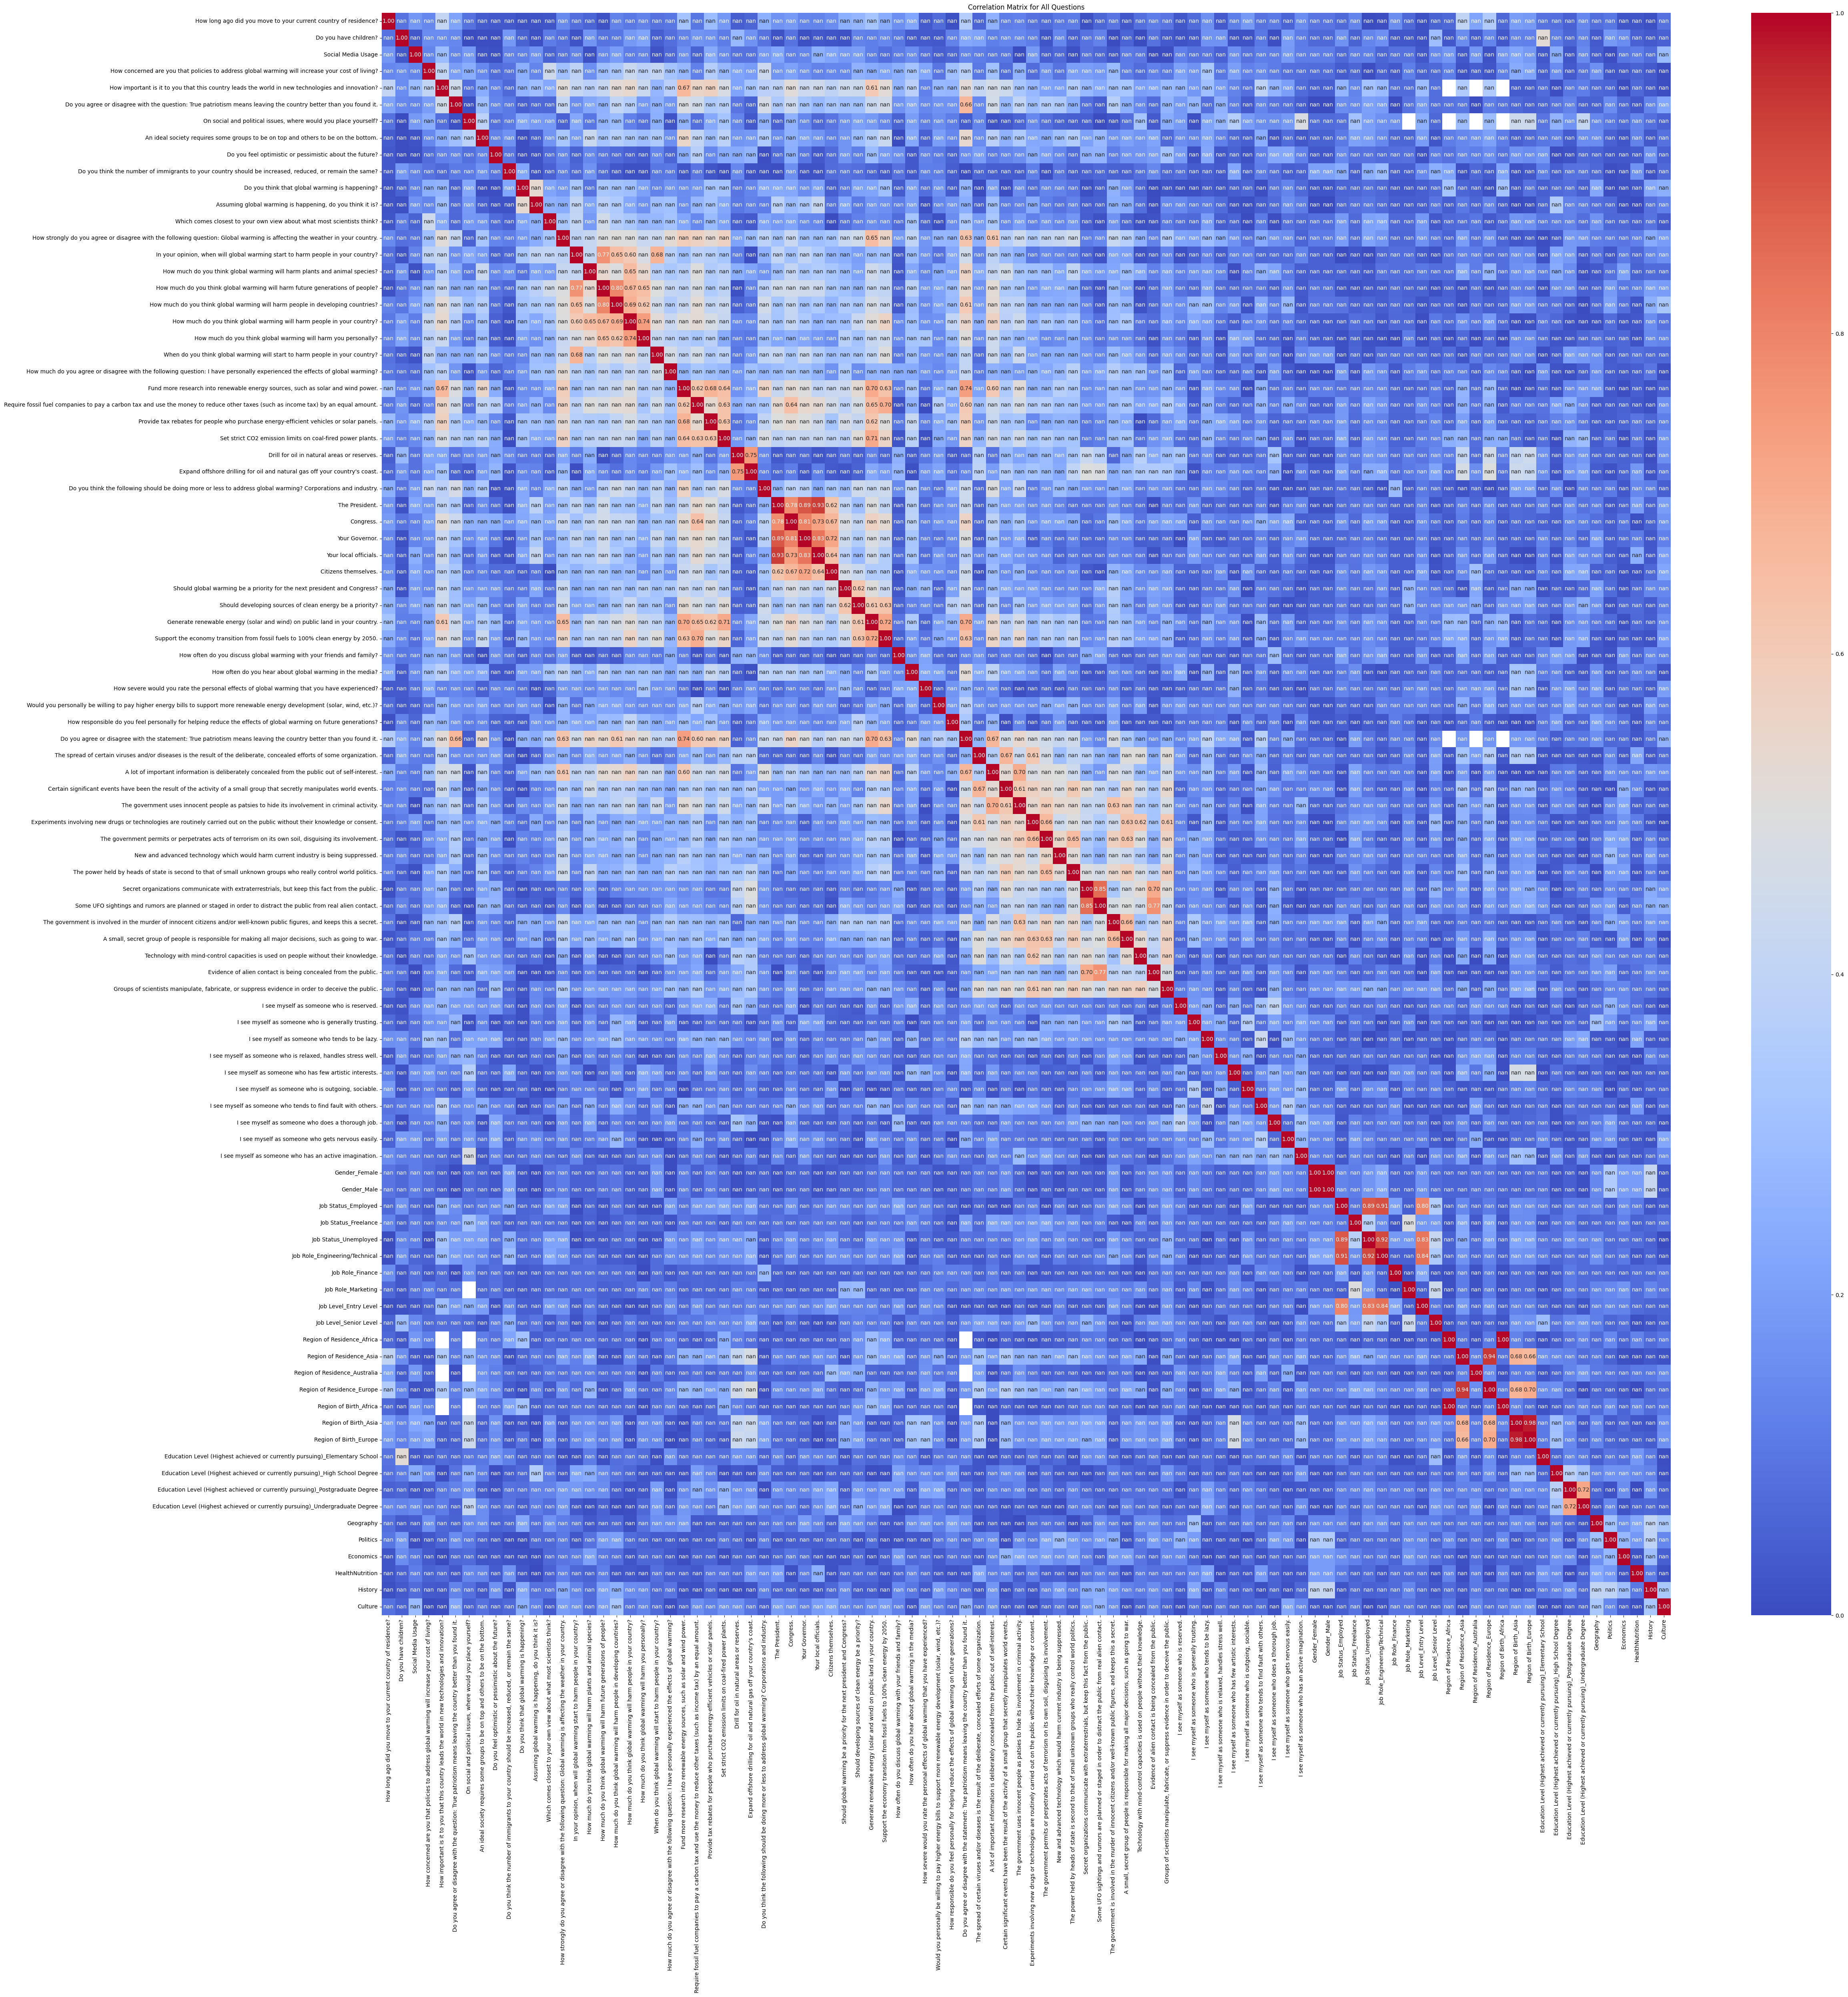

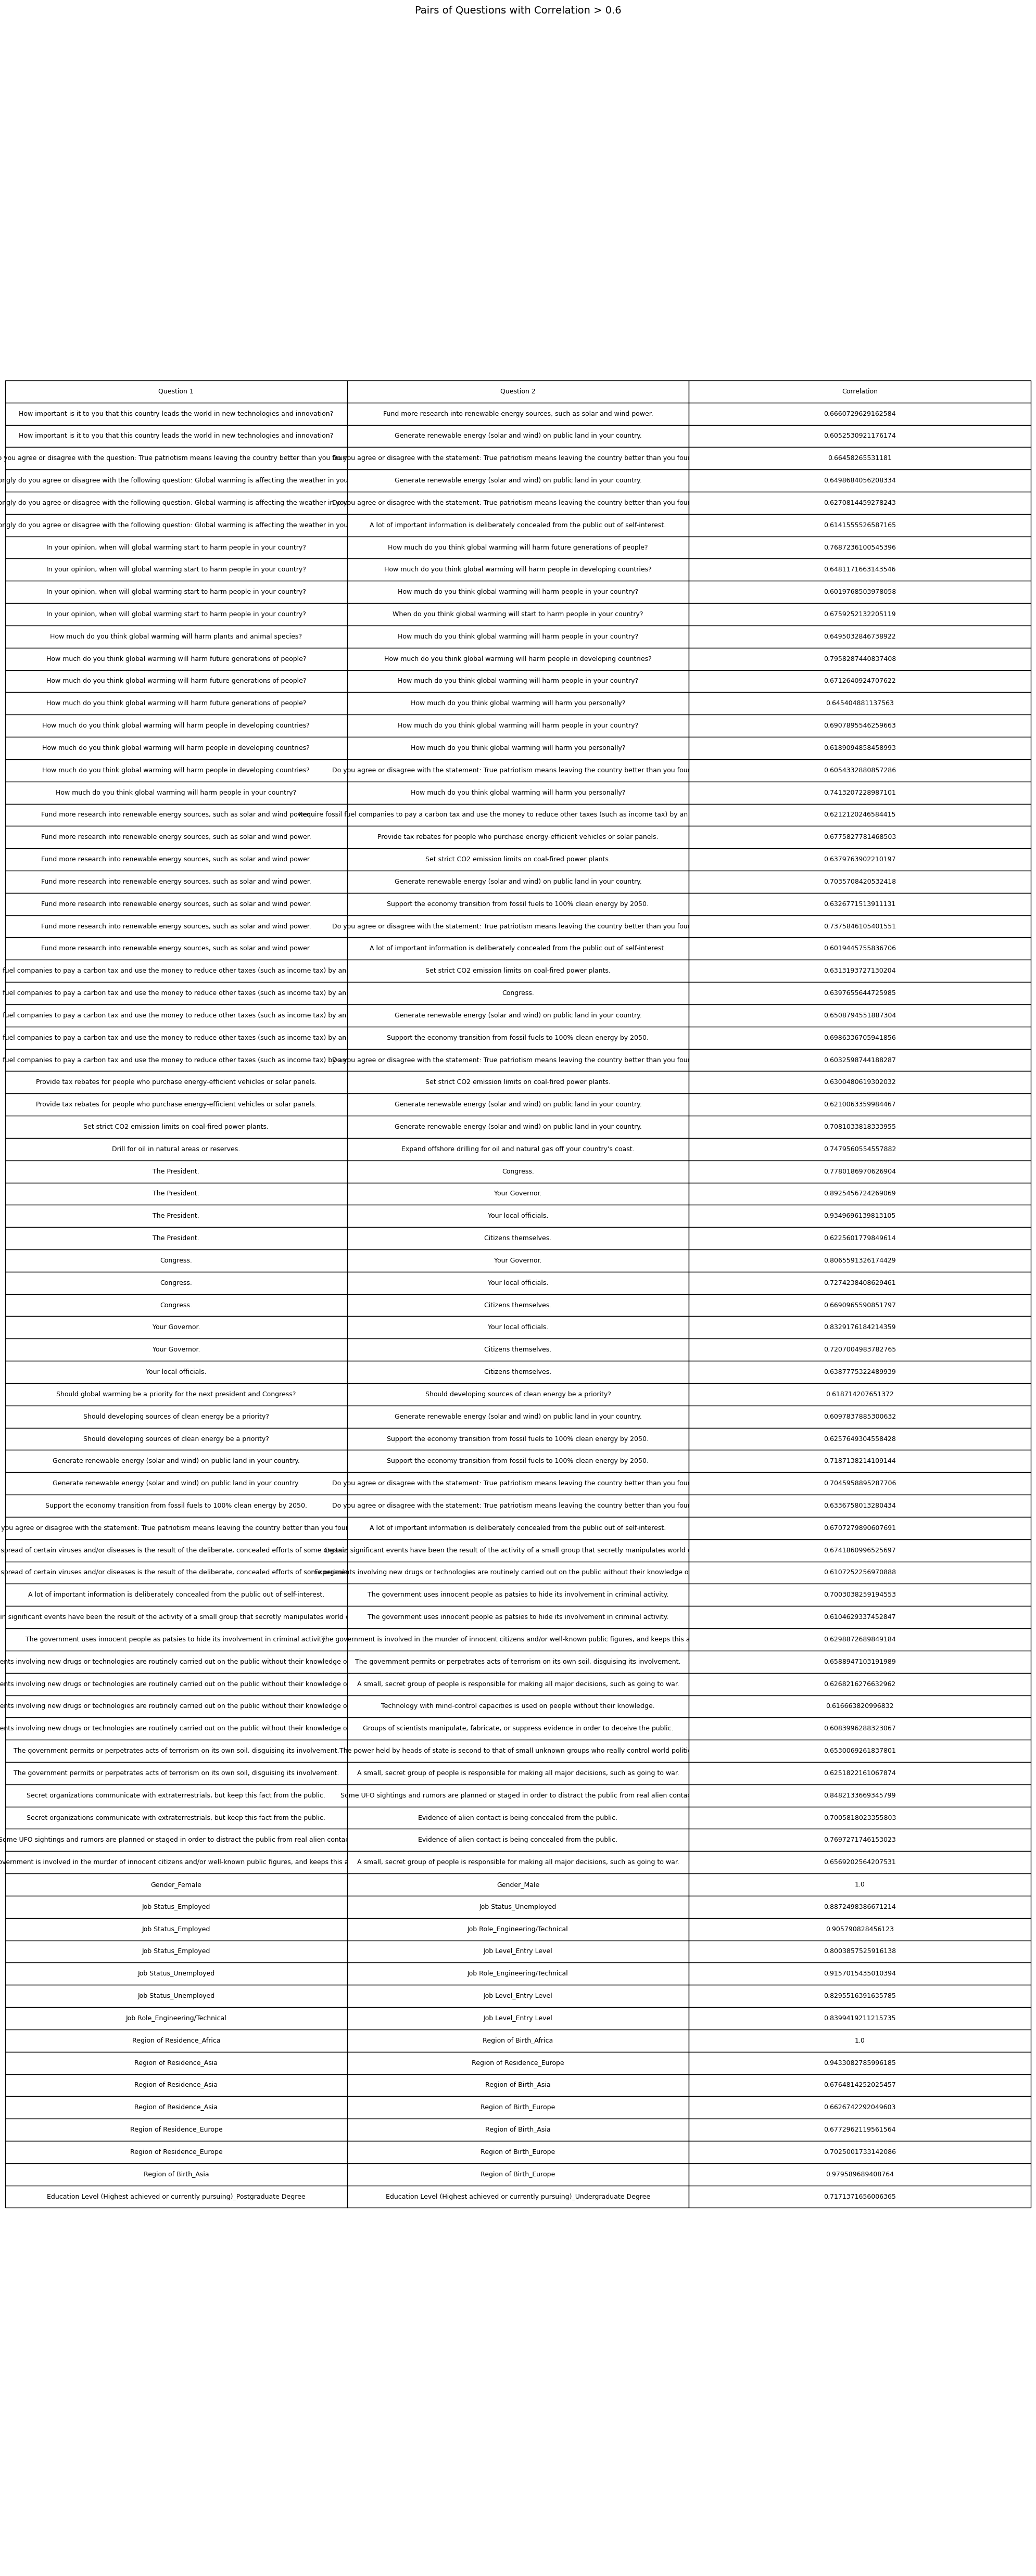

In [ ]:
#For clarity, only correlations with a value higher than 0.6 will have annotations in the correlation matrix
corr_matrix = zscore_standardize_survey(df).corr(method='pearson').abs()  # works only on numeric columns
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=0, vmax=1,
            annot=corr_matrix.where(corr_matrix > 0.6).round(2), fmt='.2f')

plt.title("Correlation Matrix for All Questions")
plt.tight_layout()
plt.show()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Finding correlations > 0.6
high_corr_pairs = (
    upper_triangle.stack()
    .reset_index()
    .rename(columns={'level_0': 'Question 1', 'level_1': 'Question 2', 0: 'Correlation'})
)

# Filtering for correlation > 0.6
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.6]

# Plot as table
plt.figure(figsize=(20, len(high_corr_pairs) * 0.6 + 1))
table = plt.table(
    cellText=high_corr_pairs.values,
    colLabels=high_corr_pairs.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
plt.axis('off')
plt.title("Pairs of Questions with Correlation > 0.6", fontsize=14)
plt.tight_layout()
plt.show()


# 8. Preliminary Analysis

In [ ]:
# Analyzing differences in climate perception by gender

# Percentage of Male vs Female Respondents
print(df.shape[0])

male_percentage = df['Gender_Male'].sum() / df.shape[0]
female_percentage = df['Gender_Female'].sum() / df.shape[0]

print(male_percentage)
print(female_percentage)



#df_grouped_gender = df.groupby('Gender').mean(numeric_only=True)

# Visualize differences
#df_grouped_gender.T.plot(kind='bar', figsize=(14, 6), title="Mean Responses by Gender")
#plt.ylabel('Mean Response')
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show()

104
0.25
0.75


# 8. Correlation Matrix for First Set of Predictors



Binary columns: ['Gender_Female', 'Gender_Male', 'Job Status_Employed', 'Job Status_Freelance', 'Job Status_Unemployed', 'Job Role_Engineering/Technical', 'Job Role_Finance', 'Job Role_Marketing', 'Job Level_Entry Level', 'Job Level_Senior Level', 'Region of Residence_Africa', 'Region of Residence_Asia', 'Region of Residence_Australia', 'Region of Residence_Europe', 'Region of Birth_Africa', 'Region of Birth_Asia', 'Region of Birth_Europe', 'Education Level (Highest achieved or currently pursuing)_Elementary School', 'Education Level (Highest achieved or currently pursuing)_High School Degree', 'Education Level (Highest achieved or currently pursuing)_Postgraduate Degree', 'Education Level (Highest achieved or currently pursuing)_Undergraduate Degree', 'Do you have children?', 'Which comes closest to your own view about what most scientists think?', 'How often do you discuss global warming with your friends and family?', 'How often do you hear about global warming in the media?']
Numer

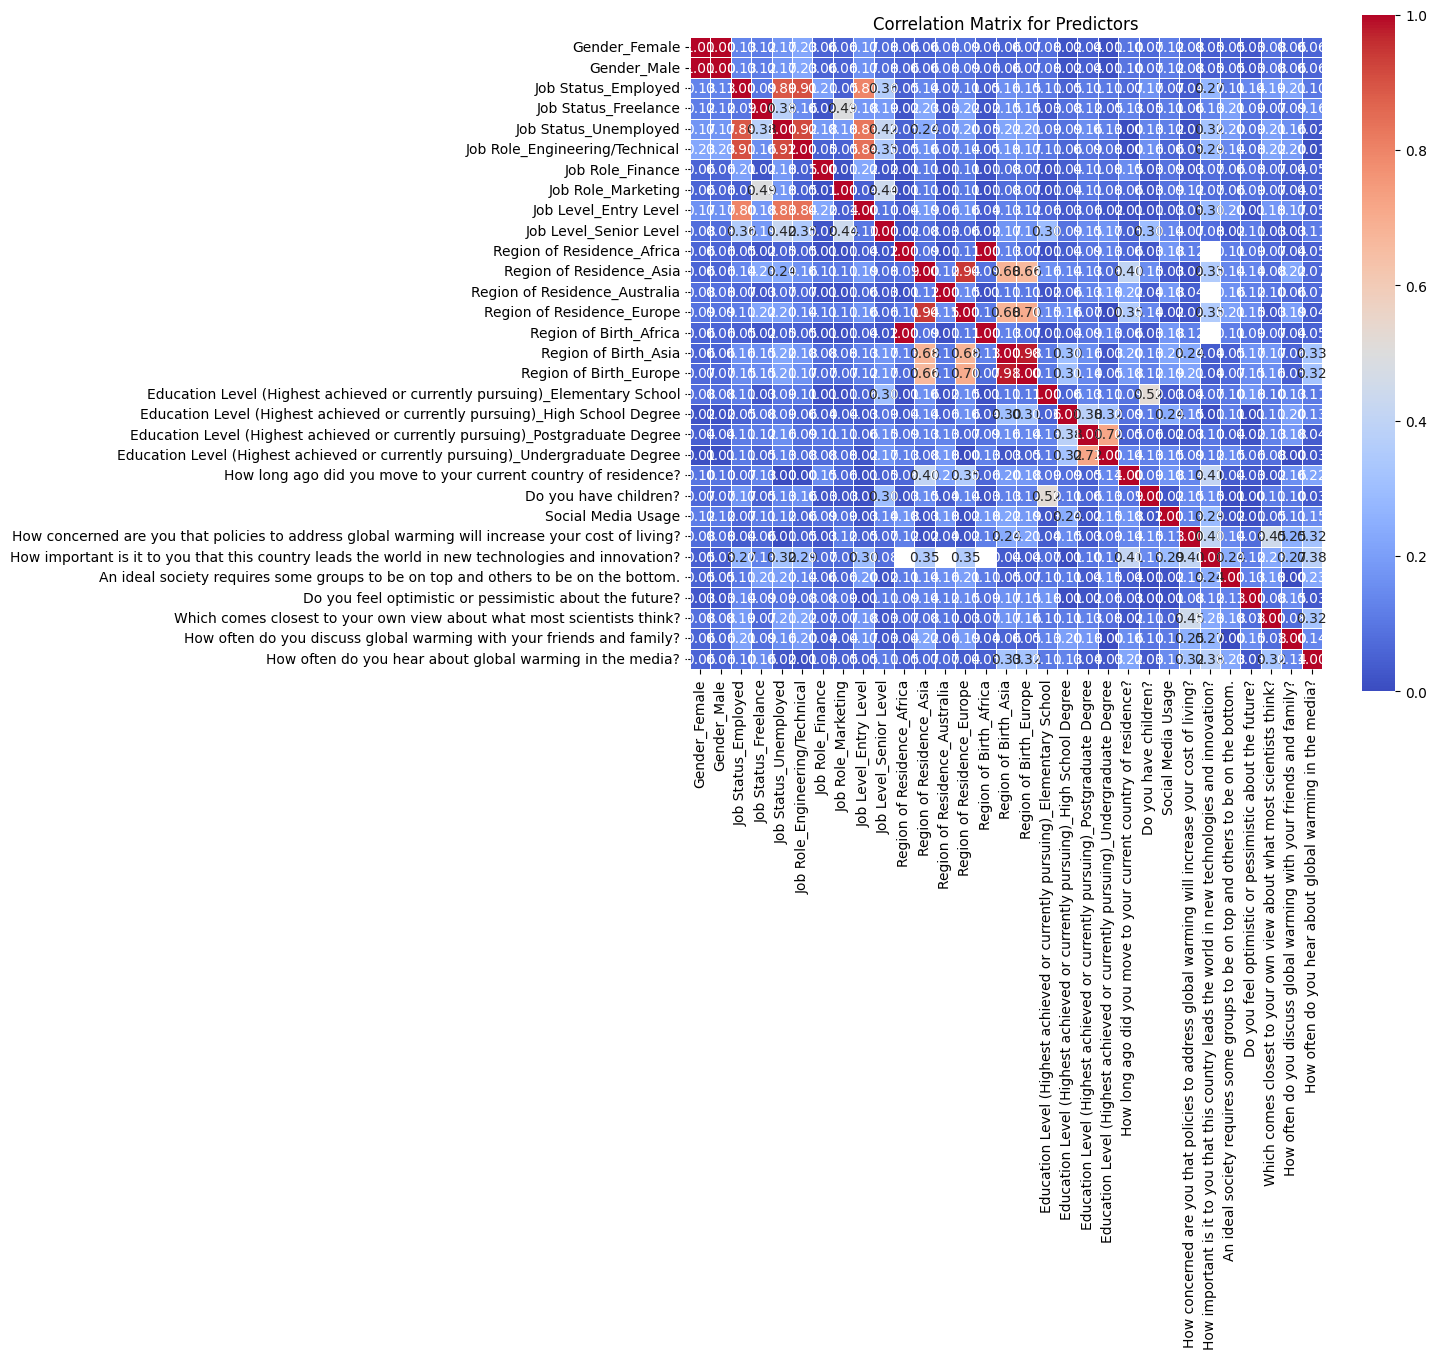

Binary columns: ['Gender_Female', 'Gender_Male', 'Job Status_Employed', 'Job Status_Freelance', 'Job Status_Unemployed', 'Job Role_Engineering/Technical', 'Job Role_Finance', 'Job Role_Marketing', 'Job Level_Entry Level', 'Job Level_Senior Level', 'Region of Residence_Africa', 'Region of Residence_Asia', 'Region of Residence_Australia', 'Region of Residence_Europe', 'Region of Birth_Africa', 'Region of Birth_Asia', 'Region of Birth_Europe', 'Education Level (Highest achieved or currently pursuing)_Elementary School', 'Education Level (Highest achieved or currently pursuing)_High School Degree', 'Education Level (Highest achieved or currently pursuing)_Postgraduate Degree', 'Education Level (Highest achieved or currently pursuing)_Undergraduate Degree', 'Do you have children?', 'Which comes closest to your own view about what most scientists think?', 'How often do you discuss global warming with your friends and family?', 'How often do you hear about global warming in the media?']
Numer

In [ ]:
predictors = [
    col for col in df.columns
    if col.startswith(('Gender_', 'Region of Birth_', 'Region of Residence_',
                       'Education Level (Highest achieved or currently pursuing)_',
                       'Education Level Highest achieved or currently pursuing_',
                       'Job Status_', 'Job Role_', 'Job Level_', 'Topic(s) of interest_'))
]

# NON-DUMMY
specific_predictors = [
    "How long ago did you move to your current country of residence?",
    "Do you have children?",
    "Social Media Usage",
    "How concerned are you that policies to address global warming will increase your cost of living?",
    "How important is it to you that this country leads the world in new technologies and innovation?",
    "Do you agree or disagree with the question True patriotism means leaving the country better than you found it.",
    "On social and political issues where would you place yourself?",
    "An ideal society requires some groups to be on top and others to be on the bottom.",
    "Do you feel optimistic or pessimistic about the future?",
    "Do you think the number of immigrants to your country should be increased reduced or remain the same?",
    "Which comes closest to your own view about what most scientists think?",
    "How much do you agree or disagree with the following question I have personally experienced the effects of global warming?",
    "How often do you discuss global warming with your friends and family?",
    "How often do you hear about global warming in the media?",
]

# Filtering specific_predictors to only include columns actually in df.columns
existing_specific_predictors = [col for col in specific_predictors if col in df.columns]

# Combining dummy and specific predictors
predictors.extend(existing_specific_predictors)

# Ensuring that all predictors in the list actually exist in the DataFrame
predictors = [col for col in predictors if col in df.columns]

df_predictors_subset = df[predictors]

corr_matrix = zscore_standardize_survey(df_predictors_subset).corr(method='pearson').abs()  # works only on numeric columns
plt.figure(figsize=(15, 15))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

plt.title("Correlation Matrix for Predictors")
plt.tight_layout()
plt.show()

df_predictors_reduced = drop_highly_correlated(df_predictors_subset, threshold=0.6)

print(f"Original shape: {df_predictors_subset.shape}")
print(f"Reduced shape: {df_predictors_reduced.shape}")

# Correlation Matrix for Climate Change Perception Questions

Binary columns: ['Do you think that global warming is happening?', 'Assuming global warming is happening, do you think it is?', 'Do you think the following should be doing more or less to address global warming? Corporations and industry.', 'The President.', 'Congress.', 'Your Governor.', 'Your local officials.', 'Citizens themselves.']
Numeric/Likert columns to be standardized: ['How strongly do you agree or disagree with the following question: Global warming is affecting the weather in your country.', 'In your opinion, when will global warming start to harm people in your country?', 'How much do you think global warming will harm plants and animal species?', 'How much do you think global warming will harm future generations of people?', 'How much do you think global warming will harm people in developing countries?', 'How much do you think global warming will harm people in your country?', 'How much do you think global warming will harm you personally?', 'When do you think global wa

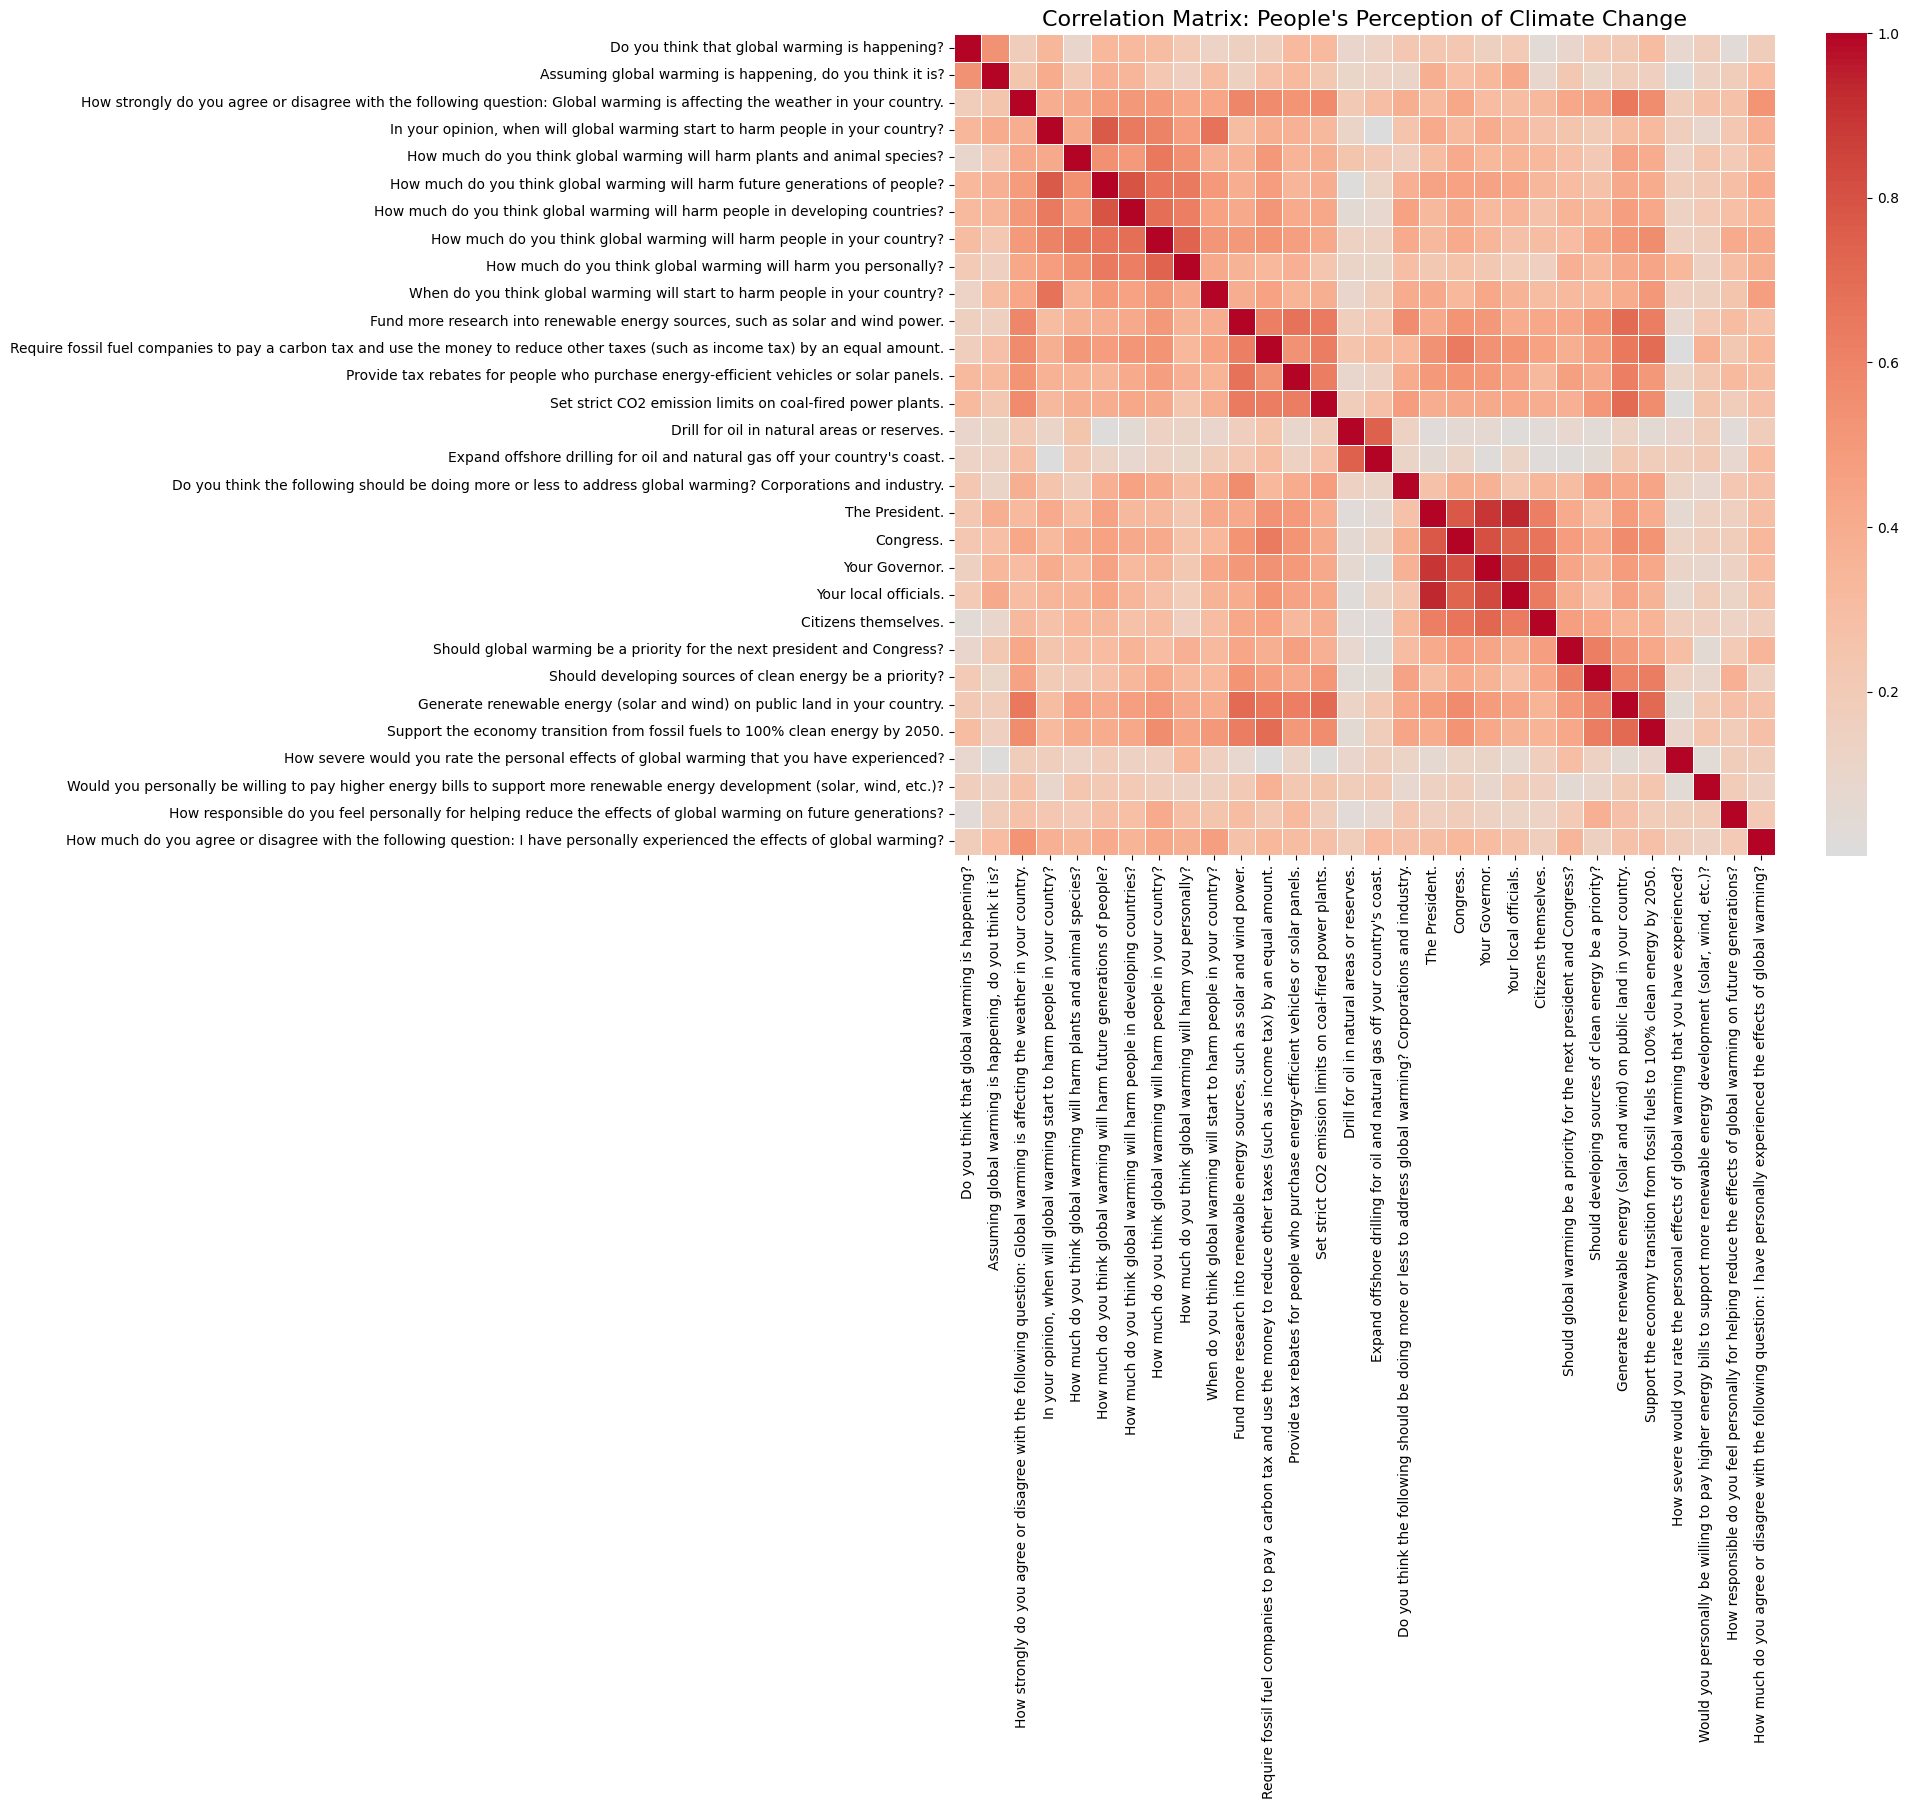

Binary columns: ['Do you think that global warming is happening?', 'Assuming global warming is happening, do you think it is?', 'Do you think the following should be doing more or less to address global warming? Corporations and industry.', 'The President.', 'Congress.', 'Your Governor.', 'Your local officials.', 'Citizens themselves.']
Numeric/Likert columns to be standardized: ['How strongly do you agree or disagree with the following question: Global warming is affecting the weather in your country.', 'In your opinion, when will global warming start to harm people in your country?', 'How much do you think global warming will harm plants and animal species?', 'How much do you think global warming will harm future generations of people?', 'How much do you think global warming will harm people in developing countries?', 'How much do you think global warming will harm people in your country?', 'How much do you think global warming will harm you personally?', 'When do you think global wa

In [ ]:
perspective_name = [
    "Do you think that global warming is happening?",
    "Assuming global warming is happening, do you think it is?",
    "How strongly do you agree or disagree with the following question: Global warming is affecting the weather in your country.",
    "In your opinion, when will global warming start to harm people in your country?",
    "How much do you think global warming will harm plants and animal species?",
    "How much do you think global warming will harm future generations of people?",
    "How much do you think global warming will harm people in developing countries?",
    "How much do you think global warming will harm people in your country?",
    "How much do you think global warming will harm you personally?",
    "When do you think global warming will start to harm people in your country?",
    "Fund more research into renewable energy sources, such as solar and wind power.",
    "Require fossil fuel companies to pay a carbon tax and use the money to reduce other taxes (such as income tax) by an equal amount.",
    "Provide tax rebates for people who purchase energy-efficient vehicles or solar panels.",
    "Set strict CO2 emission limits on coal-fired power plants.",
    "Drill for oil in natural areas or reserves.",
    "Expand offshore drilling for oil and natural gas off your country's coast.",
    "Do you think the following should be doing more or less to address global warming? Corporations and industry.",
    "The President.",
    "Congress.",
    "Your Governor.",
    "Your local officials.",
    "Citizens themselves.",
    "Should global warming be a priority for the next president and Congress?",
    "Should developing sources of clean energy be a priority?",
    "Generate renewable energy (solar and wind) on public land in your country.",
    "Support the economy transition from fossil fuels to 100% clean energy by 2050.",
    "How severe would you rate the personal effects of global warming that you have experienced?",
    "Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?",
    "How responsible do you feel personally for helping reduce the effects of global warming on future generations?",
    "How much do you agree or disagree with the following question: I have personally experienced the effects of global warming?"
]

perspective_df = df[perspective_name]
# Compute the correlation matrix
perspective_corr = zscore_standardize_survey(perspective_df).corr(method='pearson').abs()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(perspective_corr, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.7}, annot=False)

plt.title("Correlation Matrix: People's Perception of Climate Change", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

reduced_perspective_df = drop_highly_correlated(perspective_df, threshold=0.6)
print(f"Original shape: {perspective_df.shape}")
print(f"Reduced shape: {reduced_perspective_df.shape}")

perspective_df = reduced_perspective_df

print(perspective_df.columns)

# Dropping Perception Questions with Low Variance

Dropped columns: ['Do you think that global warming is happening?', 'Assuming global warming is happening, do you think it is?', 'How strongly do you agree or disagree with the following question: Global warming is affecting the weather in your country.', 'Do you think the following should be doing more or less to address global warming? Corporations and industry.', 'The President.', 'Should global warming be a priority for the next president and Congress?']


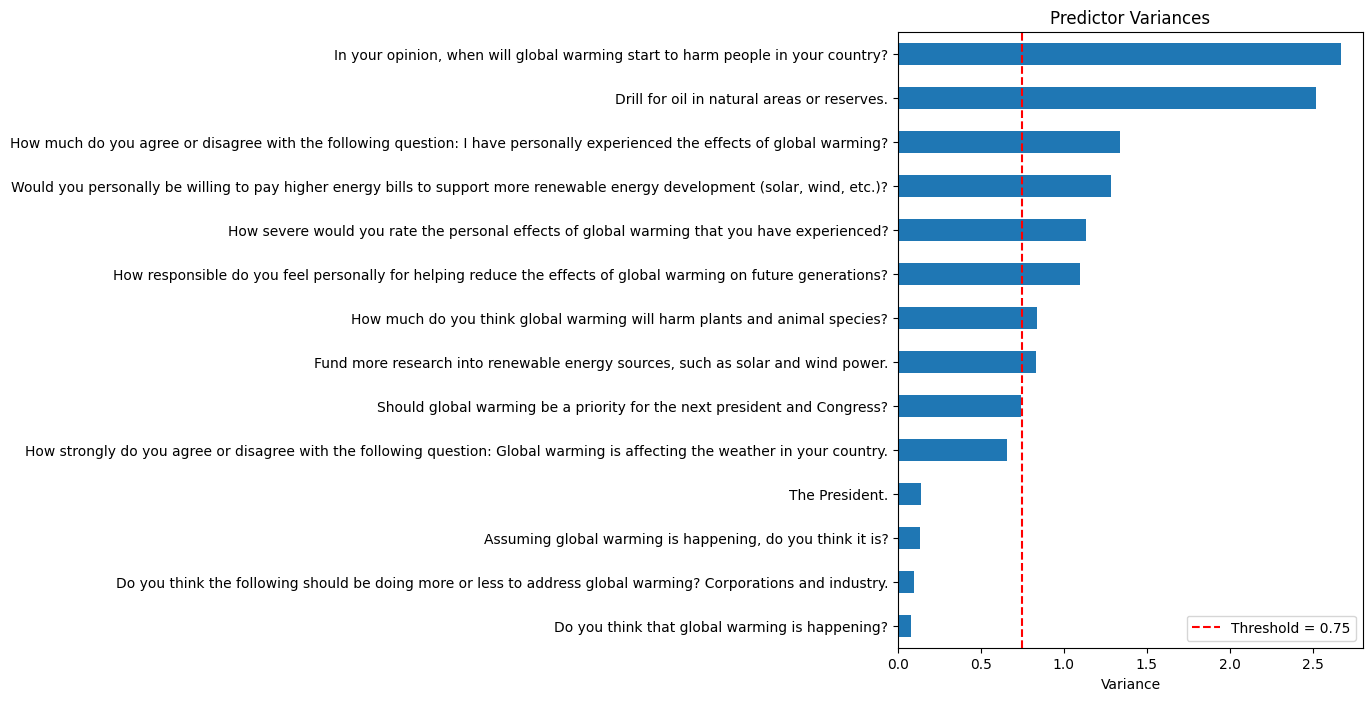

Original shape: (104, 14)
Reduced shape: (104, 8)


In [ ]:
# Calculate variance for each question [for Perspective Section]
variances = perspective_df.var()

# Set a threshold (based on the plot results)
threshold = 0.75

# Keep columns with variance above threshold
#perspective_df = perspective_df.loc[:, variances > threshold]

# Print dropped columns
dropped = variances[variances <= threshold].index.tolist()
print("Dropped columns:", dropped)

variances.sort_values().plot(kind='barh', figsize=(6, 8))
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Predictor Variances')
plt.xlabel('Variance')
plt.legend()
plt.show()

reduced_perspective_df = perspective_df.loc[:, perspective_df.var() > threshold]
print(f"Original shape: {perspective_df.shape}")
print(f"Reduced shape: {reduced_perspective_df.shape}")

perspective_df = reduced_perspective_df

# Actions Correlation Matrix

    How responsible do you feel personally for helping reduce the effects of global warming on future generations?  \
0                                                    0                                                               
1                                                    2                                                               
2                                                    4                                                               
3                                                    3                                                               
4                                                    3                                                               
..                                                 ...                                                               
99                                                   4                                                               
100                                                  2  

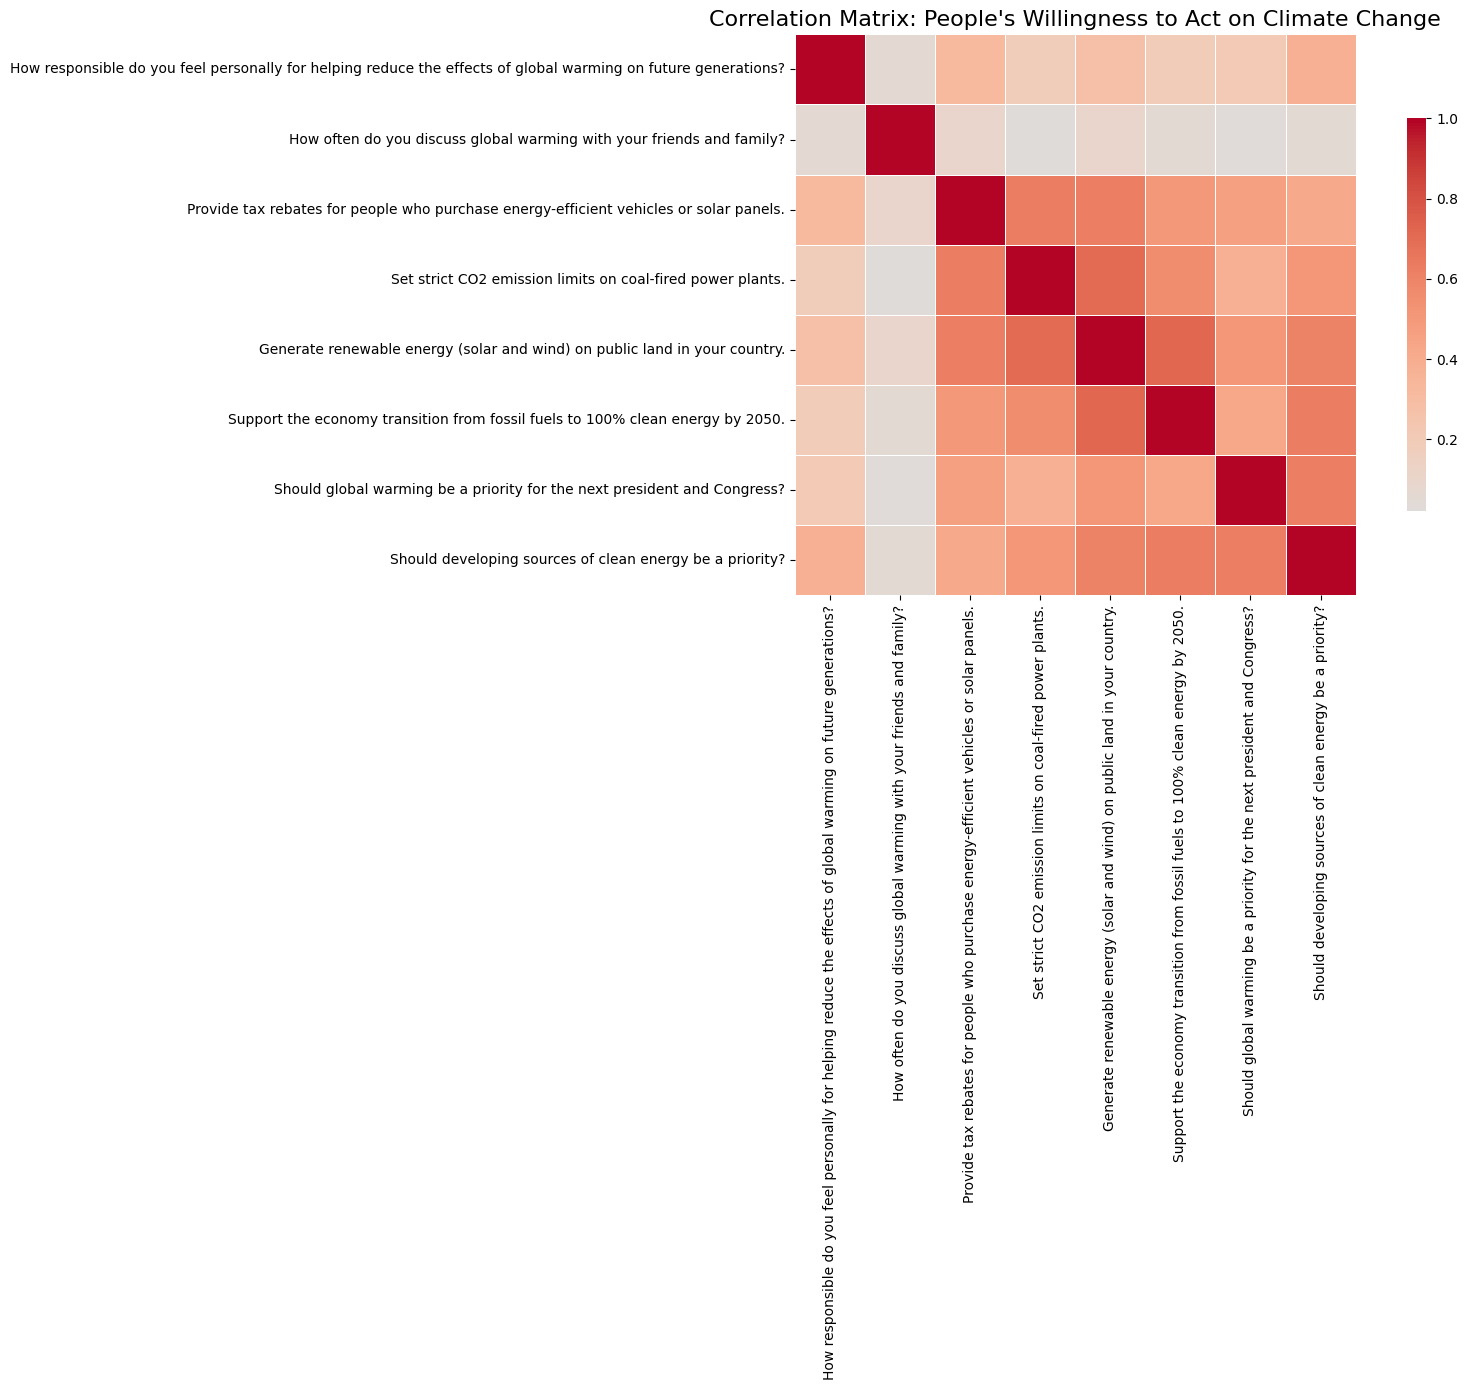

Binary columns: ['How often do you discuss global warming with your friends and family?']
Numeric/Likert columns to be standardized: ['How responsible do you feel personally for helping reduce the effects of global warming on future generations?', 'Provide tax rebates for people who purchase energy-efficient vehicles or solar panels.', 'Set strict CO2 emission limits on coal-fired power plants.', 'Generate renewable energy (solar and wind) on public land in your country.', 'Support the economy transition from fossil fuels to 100% clean energy by 2050.', 'Should global warming be a priority for the next president and Congress?', 'Should developing sources of clean energy be a priority?']
Highly correlated pairs with correlation > 0.85:

Dropping 0 columns due to high correlation:
[]
Original shape:     How responsible do you feel personally for helping reduce the effects of global warming on future generations?  \
0                                                    0                   

In [ ]:
action_cols = [
    'Would you personally be willing to pay higher energy bills to support more renewable energy development solar wind etc?',
    'How responsible do you feel personally for helping reduce the effects of global warming on future generations?',
    'How often do you discuss global warming with your friends and family?',
    'Fund more research into renewable energy sources such as solar and wind power.',
    'Require fossil fuel companies to pay a carbon tax and use the money to reduce other taxes such as income tax by an equal amount.',
    'Provide tax rebates for people who purchase energy-efficient vehicles or solar panels.',
    'Set strict CO2 emission limits on coal-fired power plants.',
    'Generate renewable energy (solar and wind) on public land in your country.',
    'Support the economy transition from fossil fuels to 100% clean energy by 2050.',
 #   'Do you think economic growth and environmental protection can go hand in hand?',
  #  'What is your opinion on implementing a carbon tax?',
   # 'Do you think the following should be doing more or less to address global warming? (Corporations, President, Congress, etc.)',
    'Should global warming be a priority for the next president and Congress?',
    'Should developing sources of clean energy be a priority?'
]
action_cols = [col for col in action_cols if col in df.columns]
# Select columns from the main dataframe
action_df = df[action_cols]
print(action_df)

# Compute the correlation matrix
action_corr = zscore_standardize_survey(action_df).corr(method='pearson').abs()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(action_corr, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.7}, annot=False)

plt.title("Correlation Matrix: People's Willingness to Act on Climate Change", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

reduced_action_df = drop_highly_correlated(action_df, threshold=0.85)
print(f"Original shape: {action_df}.shape")
print(f"Reduced shape: {reduced_action_df}.shape")

# Research Questions

In [ ]:
### Research Question 1 : 1. Is there a relationship between conspiracy mindset scores and the tendency to deny climate change?

## Step 1: Direct Correlation between Conspiracy Scores & Climate Change Perception (Trust in Scientific Studies)

#Replacing text responses with their corresponding values
#The range (0-4) was chosen based on the way the standardized test calculates
#the categorical and overall scores

replacer_conspiracy = {
    'strongly_agree': 4, 'agree': 3, 'neutral': 2,
    'disagree': 1, 'strongly_disagree': 0,
}

df_conspiracy = df_conspiracy.replace(replacer_conspiracy)

#Ensuring no errors exist within the columns
for i in [13, 9, 8, 0, 4, 12, 7, 11, 2, 10, 5, 3, 6, 14, 1]:
    df_conspiracy.iloc[:, i] = pd.to_numeric(df_conspiracy.iloc[:, i], errors='coerce')

df_conspiracy.fillna(0, inplace=True)

# 1. alien_score from columns 13, 9, 8
df_conspiracy['alien_score'] = (df_conspiracy.iloc[:, 13] + df_conspiracy.iloc[:, 9] + df_conspiracy.iloc[:, 8]) / 12 * 100

# 2. concealed_score from columns 0, 4, 12
df_conspiracy['concealed_score'] = (df_conspiracy.iloc[:, 0] + df_conspiracy.iloc[:, 4] + df_conspiracy.iloc[:, 12]) / 12 * 100

# 3. global_score from columns 7, 11, 2
df_conspiracy['global_score'] = (df_conspiracy.iloc[:, 7] + df_conspiracy.iloc[:, 11] + df_conspiracy.iloc[:, 2]) / 12 * 100

# 4. gov_score from columns 10, 5, 3
df_conspiracy['gov_score'] = (df_conspiracy.iloc[:, 10] + df_conspiracy.iloc[:, 5] + df_conspiracy.iloc[:, 3]) / 12 * 100

# 5. info_score from columns 6, 14, 1
df_conspiracy['info_score'] = (df_conspiracy.iloc[:, 6] + df_conspiracy.iloc[:, 14] + df_conspiracy.iloc[:, 1]) / 12 * 100

# Calculate deviations from respective average scores
df_conspiracy['alien_dev'] = df_conspiracy['alien_score'] - 55
df_conspiracy['concealed_dev'] = df_conspiracy['concealed_score'] - 58
df_conspiracy['global_dev'] = df_conspiracy['global_score'] - 58
df_conspiracy['gov_dev'] = df_conspiracy['gov_score'] - 70
df_conspiracy['info_dev'] = df_conspiracy['info_score'] - 72

# Calculate the overall score as the average of the 5 deviations
df_conspiracy['overall_dev'] = df_conspiracy[[
    'alien_dev', 'concealed_dev', 'global_dev', 'gov_dev', 'info_dev'
]].mean(axis=1)

# List of the six relevant columns
score_columns = [
    'alien_dev',
    'concealed_dev',
    'global_dev',
    'gov_dev',
    'info_dev',
    'overall_dev'
]

# Compute the correlation matrix to find possible correlations between individual scores
correlation_matrix_conspiracy = (df_conspiracy[score_columns]).corr()
print(correlation_matrix_conspiracy)

# Correlation with Climate Change Scientist Perception

replacer_scientists = {'Don\x92t know enough to say': 0,
 'Most scientists think global warming is happening': 1,
 'There is a lot of disagreement among scientists about whether or not global warming is happening': -1,
 'Most scientists think global warming is not happening': -2}

df['scientists_numerical'] = df.iloc[:,21].replace(replacer_scientists)
df['scientists_numerical'] = pd.to_numeric(df['scientists_numerical'], errors='coerce')
df['scientists_numerical'].fillna(0, inplace=True)

print(df['scientists_numerical'])

for col in score_columns:
       correlation3 = df_conspiracy[col].corr(df['scientists_numerical'])
       print(f"Correlation between {col} and {'Which comes closest to your own view about what most scientists think?'}: {correlation3:.4f}")

               alien_dev  concealed_dev  global_dev   gov_dev  info_dev  \
alien_dev       1.000000       0.485382    0.571088  0.458717  0.443368   
concealed_dev   0.485382       1.000000    0.734379  0.606636  0.641123   
global_dev      0.571088       0.734379    1.000000  0.782427  0.737778   
gov_dev         0.458717       0.606636    0.782427  1.000000  0.770159   
info_dev        0.443368       0.641123    0.737778  0.770159  1.000000   
overall_dev     0.733025       0.836096    0.910448  0.852771  0.842413   

               overall_dev  
alien_dev         0.733025  
concealed_dev     0.836096  
global_dev        0.910448  
gov_dev           0.852771  
info_dev          0.842413  
overall_dev       1.000000  
0      1
1      4
2      5
3      2
4      4
      ..
99     1
100    4
101    2
102    4
103    4
Name: scientists_numerical, Length: 104, dtype: int64
Correlation between alien_dev and Which comes closest to your own view about what most scientists think?: 0.1998
Corre

<ipython-input-52-2c03ffd10628>:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['scientists_numerical'].fillna(0, inplace=True)


**Logistic Regression + Confusion Matrix**

Number of 'Yes' responses: 32
Accuracy: 0.6875
Confusion Matrix:
 [[22  0]
 [10  0]]


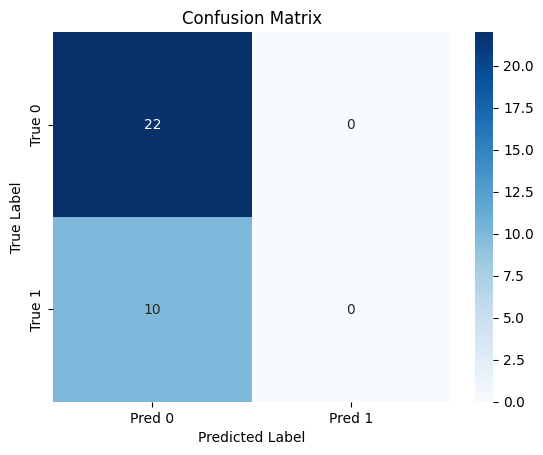

Classification Report:
               precision    recall  f1-score   support

           0       0.69      1.00      0.81        22
           1       0.00      0.00      0.00        10

    accuracy                           0.69        32
   macro avg       0.34      0.50      0.41        32
weighted avg       0.47      0.69      0.56        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
######## LOGISTIC REGRESSION+CONFUSION MATRIX RELATING CONSPIRACY THEORY TO CLIMATE BELIEF


# Binary target mapping based on numerical values
# 1 if response is <= 3 (imminent harm), else 0
df['climate_belief_binary'] = df['In your opinion, when will global warming start to harm people in your country?'].apply(
    lambda x: 1 if pd.notnull(x) and x <= 3 else 0
)


# Target summary
print("Number of 'Yes' responses:", df['climate_belief_binary'].sum())

# Define predictors correctly
# Binary: 1 if the score is negative, 0 if positive/zero
X = (df_conspiracy[['alien_dev', 'concealed_dev', 'gov_dev', 'info_dev', 'global_dev', 'overall_dev']] < 0).astype(int)
y = df['climate_belief_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict & evaluate
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Coefficient table
coeff_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coefficient': log_reg.coef_[0]
})


Binary columns: []
Numeric/Likert columns to be standardized: ['alien_dev', 'concealed_dev', 'gov_dev', 'info_dev', 'global_dev', 'In your opinion, when will global warming start to harm people in your country?']
Binary columns: []
Numeric/Likert columns to be standardized: ['alien_dev', 'concealed_dev', 'gov_dev', 'info_dev', 'global_dev', 'In your opinion, when will global warming start to harm people in your country?']
R² score for RQ1: 0.149
Mean Squared Error or RQ1: 0.755
   Predictor RQ1  Beta RQ1
0      alien_dev -0.057703
1  concealed_dev -0.229288
2        gov_dev  0.050205
3       info_dev  0.198889
4     global_dev  0.278821


<ipython-input-54-4cc4ed8644b6>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Beta RQ1', y='Predictor RQ1', data=RQ1_coef_df, palette='coolwarm')


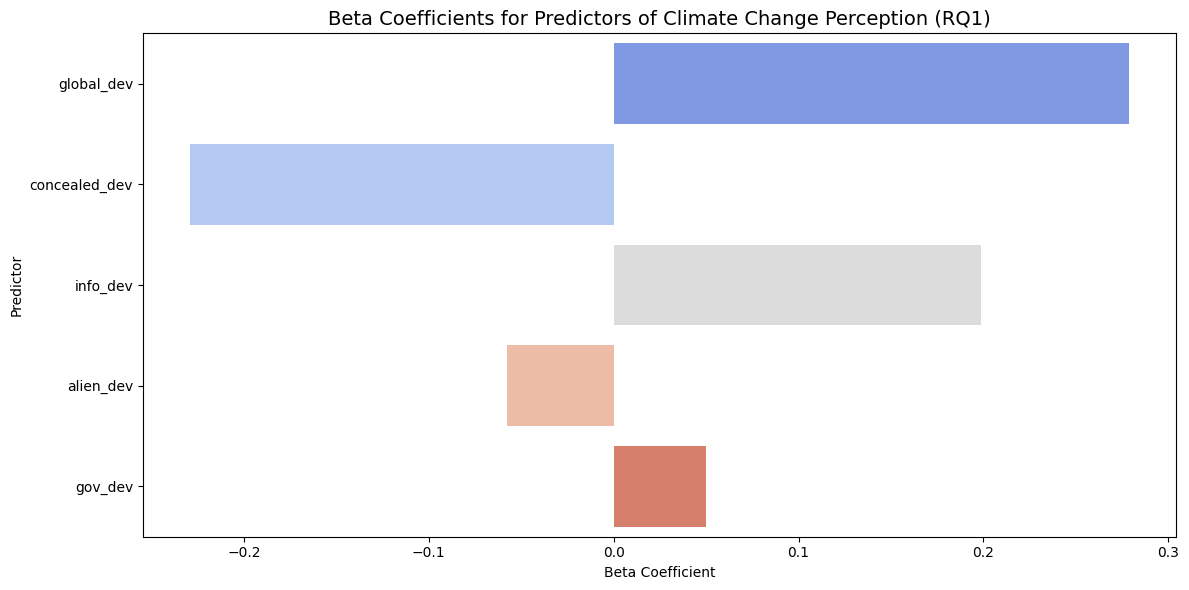

In [ ]:
## Step 2: Linear Regression for Predictive Analysis between Conspiracy Scores & Climate Change Perception (Top Question based on Correlation & Variance)

# Target Question Selection
target_research_question_1 = df['In your opinion, when will global warming start to harm people in your country?']


# Predictors Selection
predictors_research_question_1 = df_conspiracy[['alien_dev', 'concealed_dev', 'gov_dev', 'info_dev', 'global_dev']]

### Linear Regression between target and predictors
X=predictors_research_question_1
y=target_research_question_1
df_model_rq1 = pd.concat([X, y], axis=1).dropna()
X_clean_rq1 = zscore_standardize_survey(df_model_rq1).iloc[:, :-1]
y_clean_rq1 = zscore_standardize_survey(df_model_rq1).iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_clean_rq1, y_clean_rq1, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R² score for RQ1: {r2:.3f}")
print(f"Mean Squared Error or RQ1: {mse:.3f}")
# Coefficients (βs)
RQ1_coef_df = pd.DataFrame({
    'Predictor RQ1': X.columns,
    'Beta RQ1': model.coef_
})
print(RQ1_coef_df)

# Bar plot of RQ1 beta coeff
RQ1_coef_df = RQ1_coef_df.sort_values(by='Beta RQ1', key=abs, ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Beta RQ1', y='Predictor RQ1', data=RQ1_coef_df, palette='coolwarm')
plt.title("Beta Coefficients for Predictors of Climate Change Perception (RQ1)", fontsize=14)
plt.xlabel("Beta Coefficient")
plt.ylabel("Predictor")

plt.tight_layout()
plt.show()

Binary columns: ['How often do you discuss global warming with your friends and family?']
Numeric/Likert columns to be standardized: ['How concerned are you that policies to address global warming will increase your cost of living?', 'Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?', 'How responsible do you feel personally for helping reduce the effects of global warming on future generations?']
Binary columns: ['How often do you discuss global warming with your friends and family?']
Numeric/Likert columns to be standardized: ['How concerned are you that policies to address global warming will increase your cost of living?', 'Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?', 'How responsible do you feel personally for helping reduce the effects of global warming on future generations?']
Highly correlated pairs with correlation > 0.6:


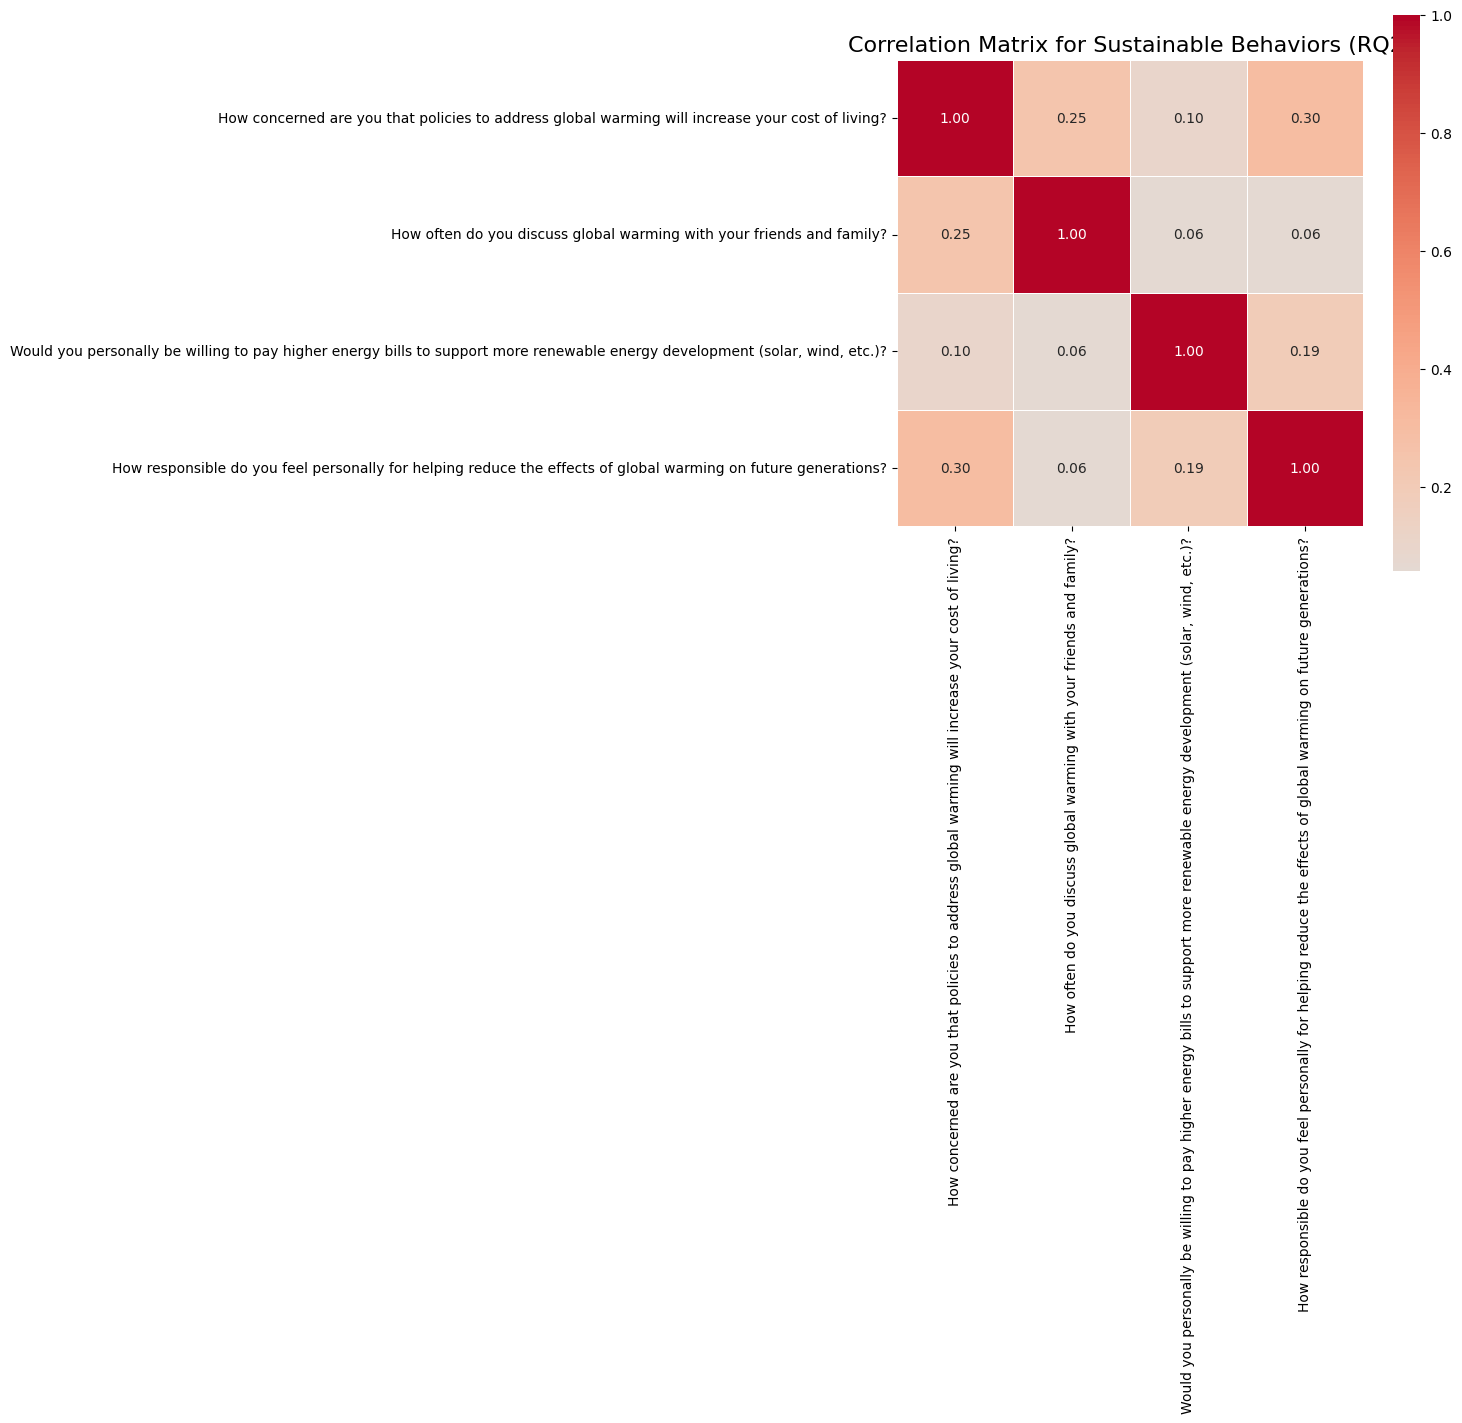

Binary columns: []
Numeric/Likert columns to be standardized: ['In your opinion, when will global warming start to harm people in your country?', 'How much do you think global warming will harm plants and animal species?', 'Fund more research into renewable energy sources, such as solar and wind power.', 'Drill for oil in natural areas or reserves.', 'How severe would you rate the personal effects of global warming that you have experienced?', 'Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?', 'How responsible do you feel personally for helping reduce the effects of global warming on future generations?', 'How much do you agree or disagree with the following question: I have personally experienced the effects of global warming?', 'How concerned are you that policies to address global warming will increase your cost of living?']
Binary columns: []
Numeric/Likert columns to be standardized: ['In your opinion, wh

<ipython-input-55-b2959b9d338f>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Beta RQ2', y='Predictor RQ2', data=RQ2_coef_df, palette='coolwarm')


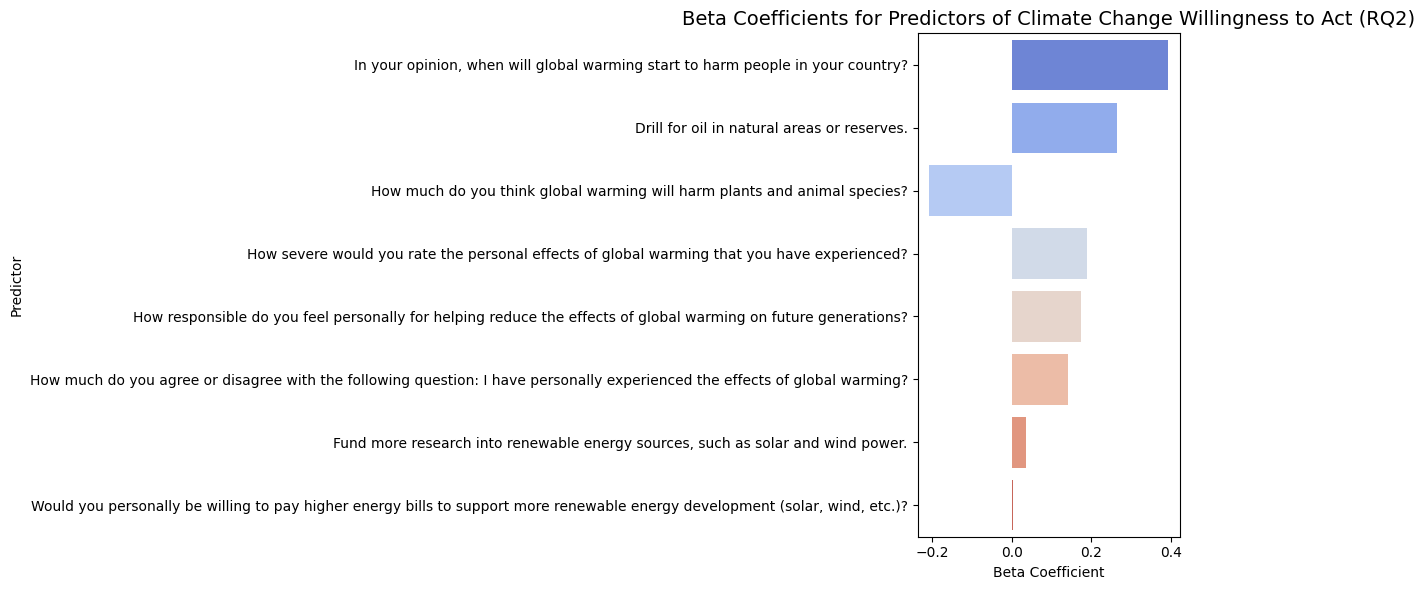

In [ ]:

### Research Question 2 : 2. Do people who claim to care about climate change actually engage in sustainable behaviors?

# Your predictors (awareness) [Based on filtration done above]
predictors_research_question_2 = perspective_df.apply(pd.to_numeric, errors='coerce')

# Your target (action)
target_research_question_2 = df[[
    "How concerned are you that policies to address global warming will increase your cost of living?",
    "How often do you discuss global warming with your friends and family?",
    "Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?",
    "How responsible do you feel personally for helping reduce the effects of global warming on future generations?"]].apply(pd.to_numeric, errors='coerce')
target_research_question_2_corr_mat = zscore_standardize_survey(target_research_question_2).corr().abs()
target_research_question_2 = drop_highly_correlated(target_research_question_2, threshold=0.6)
filtered_target_res_ques_2_corr_mat = target_research_question_2.corr().abs()
plt.figure(figsize=(15, 15))
sns.heatmap(filtered_target_res_ques_2_corr_mat,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix for Sustainable Behaviors (RQ2)', fontsize=16)
plt.tight_layout()
plt.show()

target_rq2=df[["How concerned are you that policies to address global warming will increase your cost of living?"]].apply(pd.to_numeric, errors='coerce')
### Linear Regression between target and predictors
X=predictors_research_question_2
y=target_rq2
df_model_rq2 = pd.concat([X, y], axis=1).dropna()
X_clean_rq2 = zscore_standardize_survey(df_model_rq2).iloc[:, :-1]
y_clean_rq2 = zscore_standardize_survey(df_model_rq2).iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_clean_rq2, y_clean_rq2, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R² score for RQ2: {r2:.3f}")
print(f"Mean Squared Error or RQ2: {mse:.3f}")
# Coefficients (βs)
RQ2_coef_df = pd.DataFrame({
    'Predictor RQ2': X.columns,
    'Beta RQ2': model.coef_
})
print(RQ2_coef_df)

# Bar plot of RQ1 beta coeff
RQ2_coef_df = RQ2_coef_df.sort_values(by='Beta RQ2', key=abs, ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Beta RQ2', y='Predictor RQ2', data=RQ2_coef_df, palette='coolwarm')
plt.title("Beta Coefficients for Predictors of Climate Change Willingness to Act (RQ2)", fontsize=14)
plt.xlabel("Beta Coefficient")
plt.ylabel("Predictor")

plt.tight_layout()
plt.show()


Index(['In your opinion, when will global warming start to harm people in your country?',
       'How much do you think global warming will harm plants and animal species?',
       'Fund more research into renewable energy sources, such as solar and wind power.',
       'Drill for oil in natural areas or reserves.',
       'How severe would you rate the personal effects of global warming that you have experienced?',
       'How responsible do you feel personally for helping reduce the effects of global warming on future generations?',
       'How much do you agree or disagree with the following question: I have personally experienced the effects of global warming?'],
      dtype='object')
Binary columns: ['How often do you discuss global warming with your friends and family?']
Numeric/Likert columns to be standardized: ['How concerned are you that policies to address global warming will increase your cost of living?', 'Would you personally be willing to pay higher energy bills to suppo

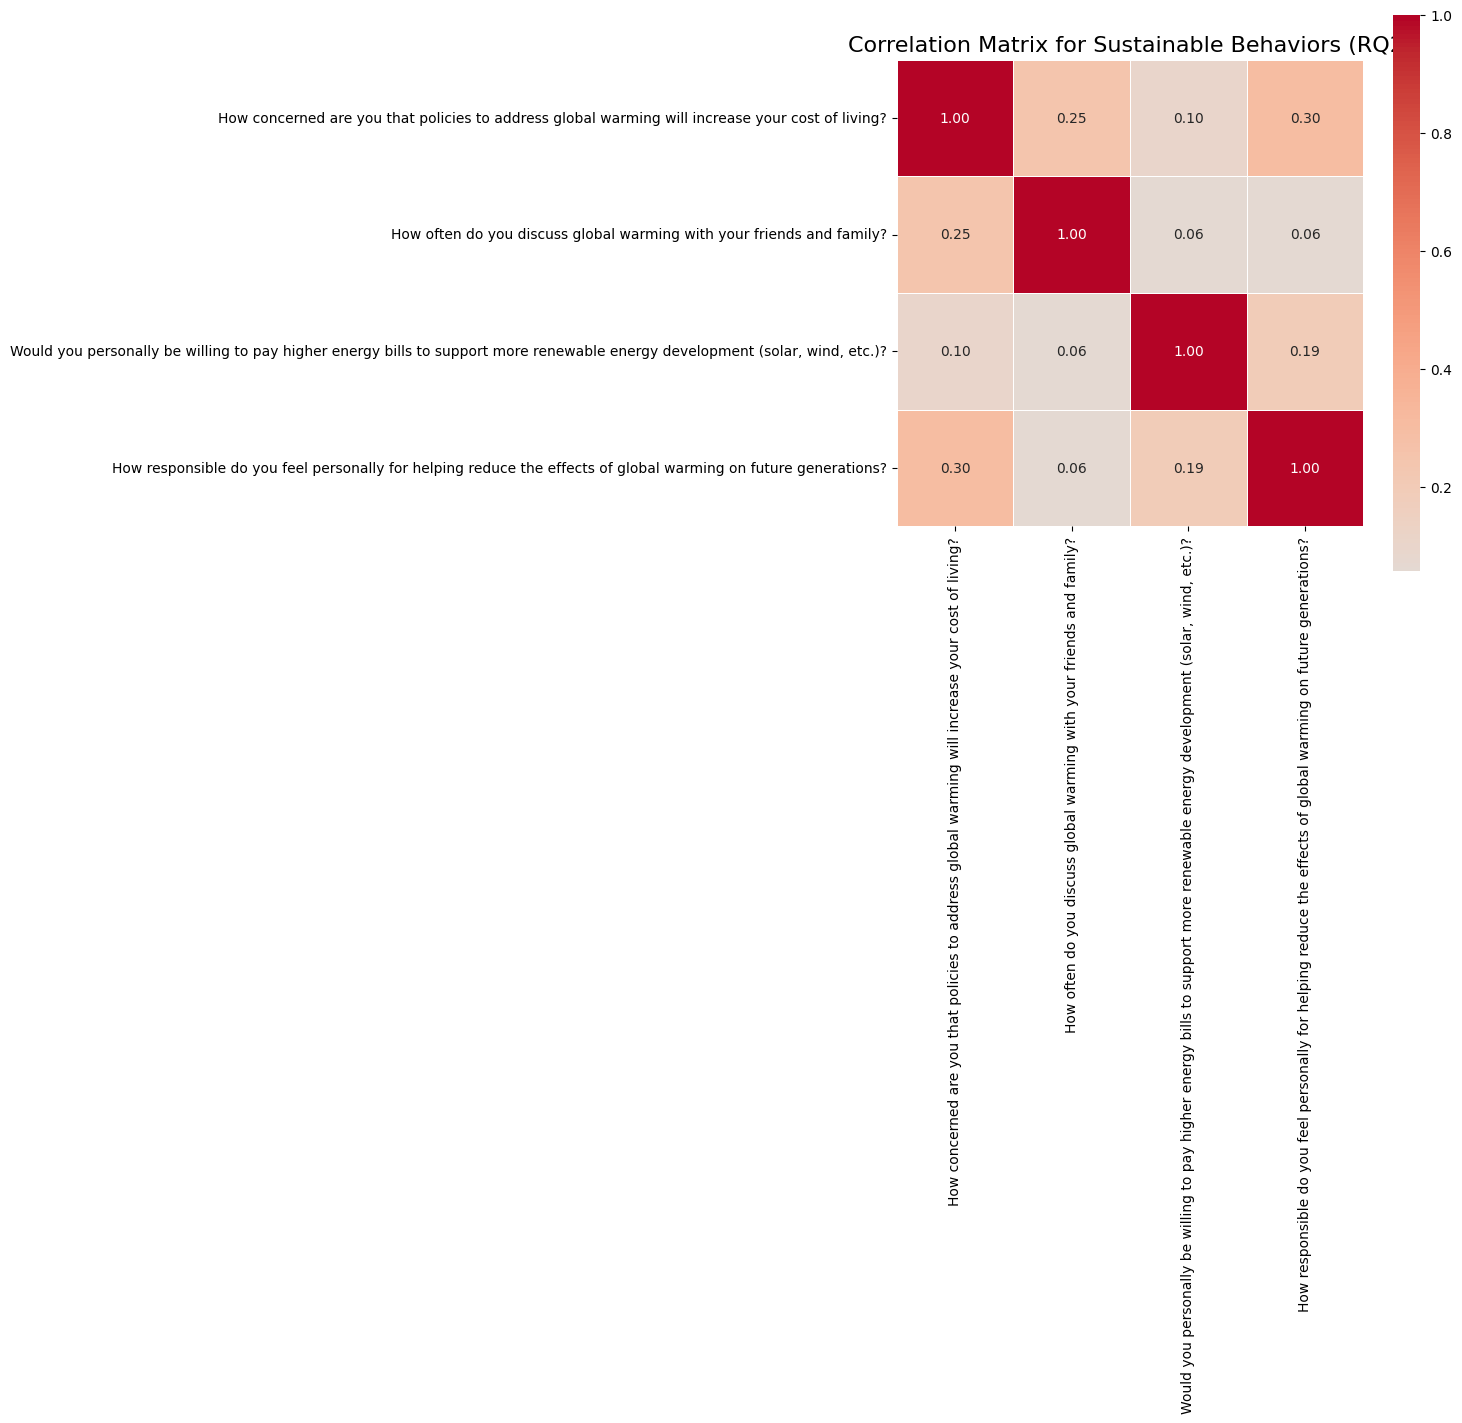

R² score: 0.170
Mean Squared Error: 0.758

Model Coefficients:
                                           Predictor      Beta
0  In your opinion, when will global warming star... -0.009367
1  How much do you think global warming will harm...  0.131299
2  Fund more research into renewable energy sourc...  0.091743
3        Drill for oil in natural areas or reserves.  0.111710
4  How severe would you rate the personal effects... -0.074837
5  How responsible do you feel personally for hel...  0.144817
6  How much do you agree or disagree with the fol... -0.012463


<ipython-input-63-2ebbbd999cf0>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Beta', y='Predictor', data=coefficients_df_sorted, palette='coolwarm')


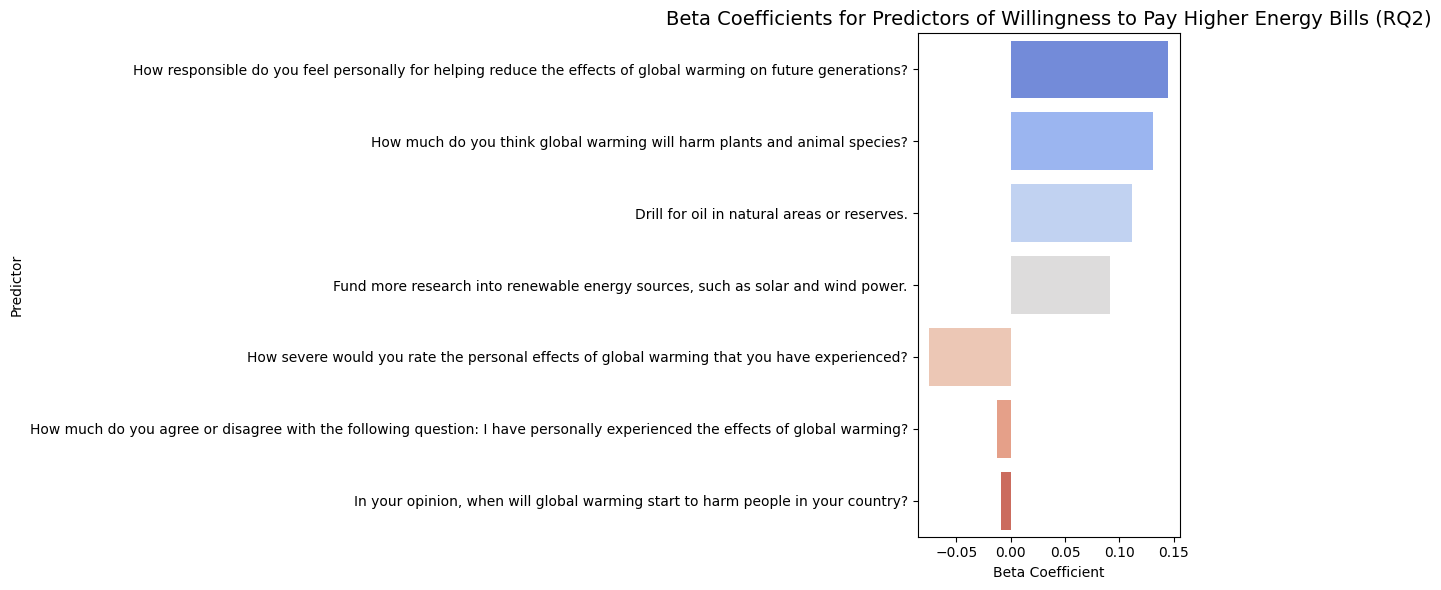

In [ ]:
## Research Question 2 : 2. Do people who claim to care about climate change actually engage in sustainable behaviors?
print(perspective_df.columns)
# Your predictors (awareness) [Based on filtration done above]
#predictors_research_question_2 = perspective_df.drop("Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?", axis=1, inplace=True)

predictors_research_question_2 = perspective_df.apply(pd.to_numeric, errors='coerce')

# Your target (action)
target_research_question_2 = df[[
    "How concerned are you that policies to address global warming will increase your cost of living?",
    "How often do you discuss global warming with your friends and family?",
    "Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?",
    "How responsible do you feel personally for helping reduce the effects of global warming on future generations?"]].apply(pd.to_numeric, errors='coerce')
target_research_question_2_corr_mat = zscore_standardize_survey(target_research_question_2).corr().abs()
target_research_question_2 = drop_highly_correlated(target_research_question_2, threshold=0.6)
filtered_target_res_ques_2_corr_mat = target_research_question_2.corr().abs()
plt.figure(figsize=(15, 15))
sns.heatmap(filtered_target_res_ques_2_corr_mat,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix for Sustainable Behaviors (RQ2)', fontsize=16)
plt.tight_layout()
plt.show()

target_rq2 = (df["Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?"].apply(pd.to_numeric, errors='coerce'))
### Linear Regression between target and predictors

df_model_rq2 = pd.concat([predictors_research_question_2, target_rq2], axis=1).dropna()

# Extract the predictors and target after cleaning
X = df_model_rq2.iloc[:, :-1]  # All columns except target
y = df_model_rq2.iloc[:, -1]   # The target column

# Step 3: Standardize the data (important for regression)
def zscore_standardize(df):
    return (df - df.mean()) / df.std()

# Standardize predictors (X) and target (y) using zscore
X_scaled = zscore_standardize(X)
y_scaled = zscore_standardize(y)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Step 5: Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R² score: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")

# Step 8: Get the model coefficients (Beta values)
coefficients_df = pd.DataFrame({
    'Predictor': X.columns,
    'Beta': model.coef_
})
print("\nModel Coefficients:")
print(coefficients_df)

# Step 9: Plot the Beta coefficients
coefficients_df_sorted = coefficients_df.sort_values(by='Beta', key=abs, ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Beta', y='Predictor', data=coefficients_df_sorted, palette='coolwarm')
plt.title("Beta Coefficients for Predictors of Willingness to Pay Higher Energy Bills (RQ2)", fontsize=14)
plt.xlabel("Beta Coefficient")
plt.ylabel("Predictor")
plt.tight_layout()
plt.show()


In [ ]:
### Research Question 3 : Which personality traits are associated with higher environmental awareness?

#Creating a replacer for the big five questions (normal scale)
replacer_bigfive_normal={'agree_strongly': 5,
    'agree_a_little': 4,
    'neutral': 3,
    'disagree_a_little': 2,
    'disagree_strongly': 1}

#Replacing the questions with the normal scale
bigfive_normal_name = ['I see myself as someone who is generally trusting.',
                       'I see myself as someone who is outgoing, sociable.',
                       'I see myself as someone who does a thorough job.',
                       'I see myself as someone who gets nervous easily.',
                       'I see myself as someone who has an active imagination.']
bigfive_df_normal = bigfive_df[bigfive_normal_name].replace(replacer_bigfive_normal)

print(bigfive_df.shape)
#Creating a replacer for the big five questions (reverse scale)
replacer_bigfive_reverse={'agree_strongly': 1,
    'agree_a_little': 2,
    'neutral': 3,
    'disagree_a_little': 4,
    'disagree_strongly': 5}

#Replacing the questions with the reverse scale
bigfive_reverse_name = ['I see myself as someone who is reserved.',
                        'I see myself as someone who tends to be lazy.',
                        'I see myself as someone who is relaxed, handles stress well.',
                        'I see myself as someone who has few artistic interests.',
                        'I see myself as someone who tends to find fault with others.']
bigfive_df_reverse = bigfive_df[bigfive_reverse_name].replace(replacer_bigfive_reverse)

#Combining all big five personality questions
bigfive_df = pd.concat([bigfive_df_normal, bigfive_df_reverse], axis=1)

#Creating new dataframe with the scored personality traits
bigfive_scored_df = pd.DataFrame()
bigfive_scored_df['Extraversion'] = bigfive_df[['I see myself as someone who is reserved.', 'I see myself as someone who is outgoing, sociable.']].mean(axis=1)
bigfive_scored_df['Agreeableness'] = bigfive_df[['I see myself as someone who is generally trusting.', 'I see myself as someone who tends to find fault with others.']].mean(axis=1)
bigfive_scored_df['Conscientiousness'] = bigfive_df[['I see myself as someone who tends to be lazy.', 'I see myself as someone who does a thorough job.']].mean(axis=1)
bigfive_scored_df['Neuroticism'] = bigfive_df[['I see myself as someone who is relaxed, handles stress well.', 'I see myself as someone who gets nervous easily.']].mean(axis=1)
bigfive_scored_df['Openness'] = bigfive_df[['I see myself as someone who has few artistic interests.', 'I see myself as someone who has an active imagination.']].mean(axis=1)

#Defining the new dataframe as our predictor dataframe
predictors_research_question_3 = bigfive_scored_df

# Your target (action)
target_rq3 = df['In your opinion, when will global warming start to harm people in your country?']

### Linear Regression between target and predictors
X=predictors_research_question_3
y=target_rq3
df_model_rq3 = pd.concat([X, y], axis=1).dropna()
X_clean_rq3 = zscore_standardize_survey(df_model_rq3).iloc[:, :-1]
y_clean_rq3 = zscore_standardize_survey(df_model_rq3).iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_clean_rq3, y_clean_rq3, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R² score for RQ3: {r2:.3f}")
print(f"Mean Squared Error or RQ3: {mse:.3f}")
# Coefficients (βs)
RQ3_coef_df = pd.DataFrame({
    'Predictor RQ3': X.columns,
    'Beta RQ3': model.coef_
})
print(RQ3_coef_df)

# Bar plot of RQ1 beta coeff
RQ3_coef_df = RQ3_coef_df.sort_values(by='Beta RQ3', key=abs, ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Beta RQ3', y='Predictor RQ3', data=RQ3_coef_df, palette='coolwarm')
plt.title("Beta Coefficients for Predictors of Climate Change Awareness(RQ3)", fontsize=14)
plt.xlabel("Beta Coefficient")
plt.ylabel("Predictor")

plt.tight_layout()
plt.show()


In [ ]:
### Research Question 4 : 4. Which interests are more associated with a higher level of environmental awareness?

# To do this we will calculate the average climate change awareness for each interest
# Average Awareness for Geography
avg_geography = (topic_dummies['Geography']*df['In your opinion, when will global warming start to harm people in your country?']).mean()

# Average Awareness for Politics
avg_politics = (topic_dummies['Politics']*df['In your opinion, when will global warming start to harm people in your country?']).mean()

# Average Awareness for Economics
avg_economics = (topic_dummies['Economics']*df['In your opinion, when will global warming start to harm people in your country?']).mean()

# Average Awareness for HealthNutrition
avg_healthnutrition = (topic_dummies['HealthNutrition']*df['In your opinion, when will global warming start to harm people in your country?']).mean()

# Average Awareness for History
avg_history = (topic_dummies['History']*df['In your opinion, when will global warming start to harm people in your country?']).mean()

# Average Awareness for Culture
avg_culture = (topic_dummies['Culture']*df['In your opinion, when will global warming start to harm people in your country?']).mean()

# Store the averages in a dictionary
avg_awareness = {
    'Geography': avg_geography,
    'Politics': avg_politics,
    'Economics': avg_economics,
    'Health/Nutrition': avg_healthnutrition,
    'History': avg_history,
    'Culture': avg_culture
}

# Convert to arrays (optional, for numerical ops)
interests = list(avg_awareness.keys())
averages_awareness = list(avg_awareness.values())

# Plot the results on a bar chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
plt.figure(figsize=(10, 6))
plt.bar(interests, averages_awareness, color=colors)
plt.title('Average Climate Awareness by Topic Interest')
plt.ylabel('Average Awareness Score')
plt.xlabel('Interest Topic')
plt.xticks(rotation=45)
plt.ylim(0, max(averages_awareness) + 1)

plt.tight_layout()
plt.show()

## Now we will repeat the same process but for the question related to exposure to climate change news
# Average Exposure for Geography
avg_geography = (topic_dummies['Geography']*df['How often do you hear about global warming in the media?']).mean()

# Average Exposure for Politics
avg_politics = (topic_dummies['Politics']*df['How often do you hear about global warming in the media?']).mean()

# Average Exposure for Economics
avg_economics = (topic_dummies['Economics']*df['How often do you hear about global warming in the media?']).mean()

# Average Exposure for HealthNutrition
avg_healthnutrition = (topic_dummies['HealthNutrition']*df['How often do you hear about global warming in the media?']).mean()

# Average Exposure for History
avg_history = (topic_dummies['History']*df['How often do you hear about global warming in the media?']).mean()

# Average Exposure for Culture
avg_culture = (topic_dummies['Culture']*df['How often do you hear about global warming in the media?']).mean()

# Store the averages in a dictionary
avg_exposure = {
    'Geography': avg_geography,
    'Politics': avg_politics,
    'Economics': avg_economics,
    'Health/Nutrition': avg_healthnutrition,
    'History': avg_history,
    'Culture': avg_culture
}

# Convert to arrays (optional, for numerical ops)
interests = list(avg_exposure.keys())
averages_exposure = list(avg_exposure.values())

# Plot the results on a bar chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
plt.figure(figsize=(10, 6))
plt.bar(interests, averages_exposure, color=colors)
plt.title('Average Climate Change Exposure by Topic Interest')
plt.ylabel('Average Climate Change Exposure Score')
plt.xlabel('Interest Topic')
plt.xticks(rotation=45)
plt.ylim(0, max(averages_exposure) + 1)

plt.tight_layout()
plt.show()

# draft question

In [ ]:
### Research Question x : x. People who trust scientists on climate change are more likely to support climate policy financially.

# Your predictors (awareness)
predictors_research_question_6 = perspective_df.apply(pd.to_numeric, errors='coerce')

# Your target (Region and Movement)
target_rq6 = df[["How concerned are you that policies to address global warming will increase your cost of living?"]].apply(pd.to_numeric, errors='coerce')

### Linear Regression between target and predictors
X_rq6 = predictors_research_question_6
y_rq6 = target_rq6
df_model_rq6 = pd.concat([X_rq6, y_rq6], axis=1).dropna()
# Separate cleaned X and y for RQ6
X_clean_rq6_plot = zscore_standardize_survey(df_model_rq6).iloc[:, :-1] # Use specific variable names for plotting
y_clean_rq6_plot = zscore_standardize_survey(df_model_rq6).iloc[:, -1] # Use specific variable names for plotting
# Split data for RQ6
X_train_rq6, X_test_rq6, y_train_rq6, y_test_rq6 = train_test_split(X_clean_rq6_plot, y_clean_rq6_plot, test_size=0.2, random_state=42)

model_rq6 = LinearRegression()
model_rq6.fit(X_train_rq6, y_train_rq6)
y_pred_rq6 = model_rq6.predict(X_test_rq6)

r2_rq6 = r2_score(y_test_rq6, y_pred_rq6)
mse_rq6 = mean_squared_error(y_test_rq6, y_pred_rq6)

print(f"R² score for RQ6: {r2_rq6:.3f}")
print(f"Mean Squared Error or RQ6: {mse_rq6:.3f}")

# Coefficient (β) for RQ6 model
beta_rq6 = model_rq6.coef_[0]
intercept_rq6 = model_rq6.intercept_

print(f"R² score: {r2_rq6:.3f}")
print(f"Mean Squared Error: {mse_rq6:.3f}")
print(f"Beta Coefficient (Trust in Scientists): {beta_rq6:.3f}")
print(f"Intercept: {intercept_rq6:.3f}")

plt.figure(figsize=(8, 5))

sns.regplot(x=X_clean_rq6_plot.values.flatten(), y=y_clean_rq6_plot.values, scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})

# sns.regplot(x=X_test_rq6.values.flatten(), y=y_test_rq6.values, scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})

plt.title("Trust in Scientists vs Willingness to Pay for Climate Policy (RQ6)") # Update title
plt.xlabel("Trust in Scientists")
plt.ylabel("Willingness to Pay")
plt.tight_layout()
plt.show()

# **Draft**

In [ ]:

################### DRAFTTTTTT
#Dummy Variables

# Define all possible topics
all_topics = ['Geography', 'Politics', 'Economics', 'HealthNutrition', 'History', 'Culture']

def multi_hot_topics(text):
    if pd.isna(text):
        return pd.Series([0]*len(all_topics), index=all_topics)
    # Split topics by space or comma
    topics = [t.strip() for t in text.replace(',', ' ').split()]
    return pd.Series([1 if topic in topics else 0 for topic in all_topics], index=all_topics)

# Apply multi-hot encoding to the Topic column
topic_dummies = df['Topic(s) of interest'].apply(multi_hot_topics)

# Concatenate topic dummies with original df (excluding original Topic column if you want)
df = pd.concat([df.drop(columns=['Topic(s) of interest']), topic_dummies], axis=1)

# Then dummy the other columns normally:
df = pd.get_dummies(df, columns=['Gender', 'Job Role','Region of Residence', 'Region of Birth', 'Education Level (Highest achieved or currently pursuing)'])

#print(df.head())

#dummy_groups = {
 #   'Gender': ['Gender_Male', 'Gender_Female'],
  #  'Education Level (Highest achieved or currently pursuing)': ['Education_High School', 'Education_Bachelor', 'Education_Master', 'Education_Doctorate'],
   # 'Job Role': ['JobRole_Manager', 'JobRole_Engineer', 'JobRole_Technician'],
    #'Region of Birth': ['Region of Birth_Africa', 'Region of Birth_Asia', 'Region of Birth_Europe', 'Region of Birth_North America', 'Region of Birth_South America'],
    #'Region of Residence': ['Region of Residence_Africa', 'Region of Residence_Asia', 'Region of Residence_Europe', 'Region of Residence_North America', 'Region of Residence_South America'],
    #'Topic(s) of interest': ['Topic(s) of interest_Geography', 'Topic(s) of interest_Politics', 'Topic(s) of interest_HealthNutrition','Topic(s) of interest_Culture','Topic(s) of interest_Economics', 'Topic(s) of interest_History']
#}

#dummies = pd.get_dummies(df[list(dummy_groups.keys())])
#df = df.drop(columns=list(dummy_groups.keys()))
#df = pd.concat([df, dummies], axis=1)
#df_encoded = pd.get_dummies(df, columns=list(dummy_groups.keys()))
print('\nAfter groupping into dummy groups: \n',df.head)
##End of dummy
#column_indices = np.arange(1, df.shape[1])
#column_names = df.columns[column_indices]
#unique_values = pd.unique(df[column_names].values.ravel())

# Drop original categorical columns that you have replaced by dummy variables
original_categorical_cols = ['Topic(s) of interest', 'Gender', 'Job Role', 'Region of Residence', 'Region of Birth', 'Education Level (Highest achieved or currently pursuing)']

# Drop if exist (some may already be dropped)
df_clean = df.drop(columns=[col for col in original_categorical_cols if col in df.columns], errors='ignore')

# Now get unique values only from dummy and numeric columns
unique_values = pd.unique(df_clean.values.ravel())

print('Unique Values without original categorical responses:', unique_values)
unique_values = pd.unique(df.values.ravel())

print('Unique Values: ',unique_values)

#Grouping the predictors index & names
predictors_gen_index = np.concatenate((np.arange(1, 10),np.arange(11, 19),np.array([21, 30, 47, 48, 52])))

predictors_gen_name = df.columns[predictors_gen_index]


df_subset = df.iloc[:, predictors_gen_index]

seen = set()
unique_values_gen_predictors = []

#for row in df_subset.itertuples(index=False):
   # for value in row:
  #      if value not in seen:
   #         seen.add(value)
 #           unique_values_gen_predictors.append(value)

#print(unique_values_gen_predictors)



#Creating a subset for the Conspiracy Questions
conspiracy_index = np.arange(53, 68)

conspiracy_name = df.columns[conspiracy_index]

df_conspiracy = df[conspiracy_name]

#Replacing text responses with their corresponding values
#The range (0-4) was chosen based on the way the standardized test calculates
#the categorical and overall scores

replacer_conspiracy = {
    'strongly_agree': 4, 'agree': 3, 'neutral': 2,
    'disagree': 1, 'strongly_disagree': 0,
}

df_conspiracy = df_conspiracy.replace(replacer_conspiracy)

#Ensuring no errors exist within the columns
for i in [13, 9, 8, 0, 4, 12, 7, 11, 2, 10, 5, 3, 6, 14, 1]:
    df_conspiracy.iloc[:, i] = pd.to_numeric(df_conspiracy.iloc[:, i], errors='coerce')

df_conspiracy.fillna(0, inplace=True)

# 1. alien_score from columns 13, 9, 8
df_conspiracy['alien_score'] = (df_conspiracy.iloc[:, 13] + df_conspiracy.iloc[:, 9] + df_conspiracy.iloc[:, 8]) / 12 * 100

# 2. concealed_score from columns 0, 4, 12
df_conspiracy['concealed_score'] = (df_conspiracy.iloc[:, 0] + df_conspiracy.iloc[:, 4] + df_conspiracy.iloc[:, 12]) / 12 * 100

# 3. global_score from columns 7, 11, 2
df_conspiracy['global_score'] = (df_conspiracy.iloc[:, 7] + df_conspiracy.iloc[:, 11] + df_conspiracy.iloc[:, 2]) / 12 * 100

# 4. gov_score from columns 10, 5, 3
df_conspiracy['gov_score'] = (df_conspiracy.iloc[:, 10] + df_conspiracy.iloc[:, 5] + df_conspiracy.iloc[:, 3]) / 12 * 100

# 5. info_score from columns 6, 14, 1
df_conspiracy['info_score'] = (df_conspiracy.iloc[:, 6] + df_conspiracy.iloc[:, 14] + df_conspiracy.iloc[:, 1]) / 12 * 100

# Calculate deviations from respective average scores
df_conspiracy['alien_dev'] = df_conspiracy['alien_score'] - 55
df_conspiracy['concealed_dev'] = df_conspiracy['concealed_score'] - 58
df_conspiracy['global_dev'] = df_conspiracy['global_score'] - 58
df_conspiracy['gov_dev'] = df_conspiracy['gov_score'] - 70
df_conspiracy['info_dev'] = df_conspiracy['info_score'] - 72

# Calculate the overall score as the average of the 5 deviations
df_conspiracy['overall_score'] = df_conspiracy[[
    'alien_dev', 'concealed_dev', 'global_dev', 'gov_dev', 'info_dev'
]].mean(axis=1)

# List of the six relevant columns
score_columns = [
    'alien_score',
    'concealed_score',
    'global_score',
    'gov_score',
    'info_score',
    'overall_score'
]

# Compute the correlation matrix to find possible correlations between individual scores
correlation_matrix = df_conspiracy[score_columns].corr()

# Define the replacement dictionary specifically for the belief column
replacer_belief = {
    'yes': 1,
    "don't know": 0,
    'no': -1,
    "donâ\x80\x99t know": 0,  # Ensure this maps the problematic string
    'no': -1 #lowercase no was added in the global replacer later, but good to have it here too
}


# Convert the target column to lowercase first to match the dictionary keys
df['Do you think that global warming is happening?'] = df['Do you think that global warming is happening?'].astype(str).str.lower()

# Apply the replacement for the belief column BEFORE calculating correlation
df['Do you think that global warming is happening?'].replace(replacer_belief, inplace=True)

# Explicitly convert the belief column to numeric after replacement
# This will turn any remaining non-numeric values into NaN
df['Do you think that global warming is happening?'] = pd.to_numeric(df['Do you think that global warming is happening?'], errors='coerce')

# Handle NaN values in the belief column if any were created by coercion
# For example, fill NaNs with 0, or use a different strategy as appropriate for your data
df['Do you think that global warming is happening?'].fillna(0, inplace=True)

#Calculate Correlation between Each Conspiracy Score & Representative Questions in Climate Perception

# Correlation with Climate Change Belief

for col in score_columns:
      # Now the correlation should work as both columns are numeric
      correlation = df_conspiracy[col].corr(df['Do you think that global warming is happening?'])
      print(f"Correlation between {col} and {'Do you think that global warming is happening?'}: {correlation:.4f}")

# Make sure the column used in the second correlation is also numeric
df.iloc[:,30] = pd.to_numeric(df.iloc[:,30], errors='coerce')
df.iloc[:,30].fillna(0, inplace=True) # Handle NaNs if any

# Correlation with Climate Change Experience
for col in score_columns:
        correlation2 = df_conspiracy[col].corr(df.iloc[:,30])
        print(f"Correlation between {col} and {'Have you felt the effects of global warming?'}: {correlation2:.4f}")

# Correlation with Climate Change Scientist Perception

replacer_scientists = {'Don\x92t know enough to say': 0,
 'Most scientists think global warming is happening': 1,
 'There is a lot of disagreement among scientists about whether or not global warming is happening': -1,
 'Most scientists think global warming is not happening': -2}

df['scientists_numerical'] = df.iloc[:,21].replace(replacer_scientists)
df['scientists_numerical'] = pd.to_numeric(df['scientists_numerical'], errors='coerce')
df['scientists_numerical'].fillna(0, inplace=True)

for col in score_columns:
       correlation3 = df_conspiracy[col].corr(df['scientists_numerical'])
       print(f"Correlation between {col} and {'Which comes closest to your own view about what most scientists think?'}: {correlation3:.4f}")


######## LOGISTIC REGRESSION+CONFUSION MATRIX
# Binary target: 1 = Yes, 0 = No or Don't know
df['climate_belief_binary'] = df['Do you think that global warming is happening?'].apply(lambda x: 1 if x == 1 else 0)

#df['climate_belief_binary'] = df['Which comes closest to your own view about what most scientists think?'].apply(lambda x: 1 if x == 'Most scientists think global warming is happening' else 0)

print(sum(df['climate_belief_binary']))

# Predictor variables: Conspiracy scores
X = df_conspiracy[['alien_score', 'concealed_score', 'global_score', 'gov_score', 'info_score', 'overall_score']]
y = df['climate_belief_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))
coeff_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coefficient': log_reg.coef_[0]
})
print(coeff_df)
# The print statements for correlation and correlation2 will only work if those
# variables were assigned values in the last loop iteration.
# It might be better to print the values within the loop if you need them.
#print(correlation)
#print(correlation2)

#########################################################

# Define indices of predictors (adjusted after dropping UserID)
predictors_gen_index = np.concatenate((np.arange(1, 10), np.arange(11, 19), np.array([21, 30, 47, 48, 52])))
predictors_gen_index = predictors_gen_index[predictors_gen_index < len(df.columns)]

# Predictor columns
predictors_gen_name = df.columns[predictors_gen_index]

# Create a copy of df to store ranked data
df_ranked = df.copy()

# For each selected predictor column, map its categories to ranks
for col in predictors_gen_name:
    unique_sorted = sorted(df[col].dropna().astype(str).unique().tolist())  # Sorted unique categories
    mapping = {val: rank for rank, val in enumerate(unique_sorted)}  # Create mapping dict

    # Replace original categorical data with ranks; leave NaNs as-is
    df_ranked[col] = df[col].map(mapping)

# Now df_ranked has numeric ranks for your predictors

# You can create a correlation matrix from these columns
corr_matrix = df_ranked[predictors_gen_name].corr(method='pearson')  # or spearman, kendall




#print(corr_matrix)


# Get absolute correlation matrix
abs_corr = corr_matrix.abs()

threshold = 0.6
to_drop = set()

# Iterate over upper triangle of the correlation matrix
for i in range(len(abs_corr.columns)):
    col_i = abs_corr.columns[i]
    if col_i in to_drop:
        continue  # Skip if already marked to drop

    for j in range(i + 1, len(abs_corr.columns)):
        col_j = abs_corr.columns[j]
        if col_j in to_drop:
            continue  # Skip if already marked to drop

        # Check correlation
        if abs_corr.iloc[i, j] >= threshold:
            to_drop.add(col_j)

print("Questions to drop due to high correlation:", to_drop)

# Remaining columns after dropping highly correlated ones
cols_to_keep = [col for col in corr_matrix.columns if col not in to_drop]
print("Questions to keep:", cols_to_keep)
df_filtered = df_ranked[cols_to_keep]

# Plot the correlation matrix as a heatmap for Predictors
plt.figure(figsize=(16, 12))
# Changed perspective_corr to corr_matrix here
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.7}, annot=False)

plt.title("Correlation Matrix: Predictors", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
#######################################Correlation Matrix of perspective questions
# Corrected the way the list of column names is defined.
# It should be a list of strings, not a single list containing multiple strings
perspective_cols = [
    'Do you think that global warming is happening?',
     'Assuming global warming is happening, do you think it is?',
    'Which comes closest to your own view about what most scientists think?',
    'How strongly do you agree or disagree with the following question: Global warming is affecting the weather in your country.',
    'How much do you think global warming will harm plants and animal species?',
    'How much do you think global warming will harm future generations of people?',
    'How much do you think global warming will harm people in developing countries?',
    'How much do you think global warming will harm people in your country?',
    'How much do you think global warming will harm you personally?',
  #  'How much do you agree or disagree with the following question: “I have personally experienced the effects of global warming”?',
 #   'Do you believe that pollution levels were lower in the past than they are today?',
  #  'Do you feel that climate change is making it harder to find healthy food where you live?',
   # 'Do you think air pollution from climate change is affecting your health or the food you eat?',
    #'Do you know the Paris Agreement?',
    #'Do you think we are living in the worst period in history when it comes to the climate crisis?'
]
# Select columns from the main dataframe
perspective_df = df[perspective_cols]

# Convert categorical responses to numeric (ordinal encoding)
# This approach might not be suitable if the columns have varying categories.
# A better approach might involve one-hot encoding or a more robust ordinal encoding per column.
# For simplicity and to match the user's apparent intent, we'll stick to factorize for now.
# However, be aware that factorize assigns numeric IDs based on order of appearance, not inherent order.
perspective_numeric = perspective_df.apply(lambda x: pd.factorize(x)[0])

# Compute the correlation matrix
perspective_corr = perspective_numeric.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(perspective_corr, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.7}, annot=False)

plt.title("Correlation Matrix: People's Perception of Climate Change", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
for i in range(len(perspective_corr.columns)):
    col_i = perspective_corr.columns[i]
    if col_i in to_drop:
        continue  # Skip if already marked to drop

    for j in range(i + 1, len(perspective_corr.columns)):
        col_j = perspective_corr.columns[j]
        if col_j in to_drop:
            continue  # Skip if already marked to drop

        # Check correlation
        if perspective_corr.iloc[i, j] >= threshold:
            to_drop.add(col_j)

print("Perspective predictors to drop due to high correlation:", to_drop)
cols_to_keep = [col for col in perspective_corr.columns if col not in to_drop]
print("Perspective predictors to keep:", cols_to_keep)
df_filtered = df_ranked[cols_to_keep]

######################################Correlation Matrix of people's willingness to act questions
# Corrected the way the list of column names is defined.
# It should be a list of strings, not a single list containing multiple strings
action_cols = [
    'Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?',
    'How responsible do you feel personally for helping reduce the effects of global warming on future generations?',
    'How often do you discuss global warming with your friends and family?',
    'Fund more research into renewable energy sources, such as solar and wind power.',
    'Require fossil fuel companies to pay a carbon tax and use the money to reduce other taxes (such as income tax) by an equal amount.',
    'Provide tax rebates for people who purchase energy-efficient vehicles or solar panels.',
    'Set strict CO2 emission limits on coal-fired power plants.',
    'Generate renewable energy (solar and wind) on public land in your country.',
    'Support the economy transition from fossil fuels to 100% clean energy by 2050.',
 #   'Do you think economic growth and environmental protection can go hand in hand?',
  #  'What is your opinion on implementing a carbon tax?',
   # 'Do you think the following should be doing more or less to address global warming? (Corporations, President, Congress, etc.)',
    'Should global warming be a priority for the next president and Congress?',
    'Should developing sources of clean energy be a priority?'
]
# Select columns from the main dataframe
action_df = df[action_cols]

# Convert categorical responses to numeric (ordinal encoding)
# Similar to perspective_numeric, be mindful of how factorize assigns values.
action_numeric = action_df.apply(lambda x: pd.factorize(x)[0])

# Compute the correlation matrix
action_corr = action_numeric.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(action_corr, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.7}, annot=False)

plt.title("Correlation Matrix: People's Willingness to Act on Climate Change", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
for i in range(len(action_corr.columns)):
    col_i = action_corr.columns[i]
    if col_i in to_drop:
        continue  # Skip if already marked to drop

    for j in range(i + 1, len(action_corr.columns)):
        col_j = action_corr.columns[j]
        if col_j in to_drop:
            continue  # Skip if already marked to drop

        # Check correlation
        if action_corr.iloc[i, j] >= threshold:
            to_drop.add(col_j)

print("Action predictors to drop due to high correlation:", to_drop)
cols_to_keep = [col for col in perspective_corr.columns if col not in to_drop]
print("Action predictors to keep:", cols_to_keep)
df_filtered = df_ranked[cols_to_keep]

#########Print dataset after filtration
print('\nDataset after Preprocessing and Filtration: ',df)

#Grouping the predictors index & names
predictors_gen_index = np.concatenate((np.arange(1, 10),np.arange(11, 19),np.array([21, 30, 47, 48, 52])))

predictors_gen_name = df.columns[predictors_gen_index]


df_subset = df.iloc[:, predictors_gen_index]

seen = set()
unique_values_gen_predictors = []

#for row in df_subset.itertuples(index=False):
   # for value in row:
  #      if value not in seen:
   #         seen.add(value)
 #           unique_values_gen_predictors.append(value)

#print(unique_values_gen_predictors)



#Creating a subset for the Conspiracy Questions
conspiracy_index = np.arange(53, 68)

conspiracy_name = df.columns[conspiracy_index]

df_conspiracy = df[conspiracy_name]

#Replacing text responses with their corresponding values
#The range (0-4) was chosen based on the way the standardized test calculates
#the categorical and overall scores

replacer_conspiracy = {
    'strongly_agree': 4, 'agree': 3, 'neutral': 2,
    'disagree': 1, 'strongly_disagree': 0,
}

df_conspiracy = df_conspiracy.replace(replacer_conspiracy)

#Ensuring no errors exist within the columns
for i in [13, 9, 8, 0, 4, 12, 7, 11, 2, 10, 5, 3, 6, 14, 1]:
    df_conspiracy.iloc[:, i] = pd.to_numeric(df_conspiracy.iloc[:, i], errors='coerce')

df_conspiracy.fillna(0, inplace=True)

# 1. alien_score from columns 13, 9, 8
df_conspiracy['alien_score'] = (df_conspiracy.iloc[:, 13] + df_conspiracy.iloc[:, 9] + df_conspiracy.iloc[:, 8]) / 12 * 100

# 2. concealed_score from columns 0, 4, 12
df_conspiracy['concealed_score'] = (df_conspiracy.iloc[:, 0] + df_conspiracy.iloc[:, 4] + df_conspiracy.iloc[:, 12]) / 12 * 100

# 3. global_score from columns 7, 11, 2
df_conspiracy['global_score'] = (df_conspiracy.iloc[:, 7] + df_conspiracy.iloc[:, 11] + df_conspiracy.iloc[:, 2]) / 12 * 100

# 4. gov_score from columns 10, 5, 3
df_conspiracy['gov_score'] = (df_conspiracy.iloc[:, 10] + df_conspiracy.iloc[:, 5] + df_conspiracy.iloc[:, 3]) / 12 * 100

# 5. info_score from columns 6, 14, 1
df_conspiracy['info_score'] = (df_conspiracy.iloc[:, 6] + df_conspiracy.iloc[:, 14] + df_conspiracy.iloc[:, 1]) / 12 * 100

# Calculate deviations from respective average scores
df_conspiracy['alien_dev'] = df_conspiracy['alien_score'] - 55
df_conspiracy['concealed_dev'] = df_conspiracy['concealed_score'] - 58
df_conspiracy['global_dev'] = df_conspiracy['global_score'] - 58
df_conspiracy['gov_dev'] = df_conspiracy['gov_score'] - 70
df_conspiracy['info_dev'] = df_conspiracy['info_score'] - 72

# Calculate the overall score as the average of the 5 deviations
df_conspiracy['overall_score'] = df_conspiracy[[
    'alien_dev', 'concealed_dev', 'global_dev', 'gov_dev', 'info_dev'
]].mean(axis=1)

# List of the six relevant columns
score_columns = [
    'alien_score',
    'concealed_score',
    'global_score',
    'gov_score',
    'info_score',
    'overall_score'
]

# Compute the correlation matrix to find possible correlations between individual scores
correlation_matrix = df_conspiracy[score_columns].corr()

# Define the replacement dictionary specifically for the belief column
replacer_belief = {
    'yes': 1,
    "don't know": 0,
    'no': -1,
    "donâ\x80\x99t know": 0,  # Ensure this maps the problematic string
    'no': -1 #lowercase no was added in the global replacer later, but good to have it here too
}


# Convert the target column to lowercase first to match the dictionary keys
df['Do you think that global warming is happening?'] = df['Do you think that global warming is happening?'].astype(str).str.lower()

# Apply the replacement for the belief column BEFORE calculating correlation
df['Do you think that global warming is happening?'].replace(replacer_belief, inplace=True)

# Explicitly convert the belief column to numeric after replacement
# This will turn any remaining non-numeric values into NaN
df['Do you think that global warming is happening?'] = pd.to_numeric(df['Do you think that global warming is happening?'], errors='coerce')

# Handle NaN values in the belief column if any were created by coercion
# For example, fill NaNs with 0, or use a different strategy as appropriate for your data
df['Do you think that global warming is happening?'].fillna(0, inplace=True)

#Calculate Correlation between Each Conspiracy Score & Representative Questions in Climate Perception

# Correlation with Climate Change Belief

for col in score_columns:
      # Now the correlation should work as both columns are numeric
      correlation = df_conspiracy[col].corr(df['Do you think that global warming is happening?'])
      print(f"Correlation between {col} and {'Do you think that global warming is happening?'}: {correlation:.4f}")

# Make sure the column used in the second correlation is also numeric
df.iloc[:,30] = pd.to_numeric(df.iloc[:,30], errors='coerce')
df.iloc[:,30].fillna(0, inplace=True) # Handle NaNs if any

# Correlation with Climate Change Experience
for col in score_columns:
        correlation2 = df_conspiracy[col].corr(df.iloc[:,30])
        print(f"Correlation between {col} and {'Have you felt the effects of global warming?'}: {correlation2:.4f}")

# Correlation with Climate Change Scientist Perception

replacer_scientists = {'Don\x92t know enough to say': 0,
 'Most scientists think global warming is happening': 1,
 'There is a lot of disagreement among scientists about whether or not global warming is happening': -1,
 'Most scientists think global warming is not happening': -2}

df['scientists_numerical'] = df.iloc[:,21].replace(replacer_scientists)
df['scientists_numerical'] = pd.to_numeric(df['scientists_numerical'], errors='coerce')
df['scientists_numerical'].fillna(0, inplace=True)

for col in score_columns:
       correlation3 = df_conspiracy[col].corr(df['scientists_numerical'])
       print(f"Correlation between {col} and {'Which comes closest to your own view about what most scientists think?'}: {correlation3:.4f}")


######## LOGISTIC REGRESSION+CONFUSION MATRIX
# Binary target: 1 = Yes, 0 = No or Don't know
df['climate_belief_binary'] = df['Do you think that global warming is happening?'].apply(lambda x: 1 if x == 1 else 0)

#df['climate_belief_binary'] = df['Which comes closest to your own view about what most scientists think?'].apply(lambda x: 1 if x == 'Most scientists think global warming is happening' else 0)

print(sum(df['climate_belief_binary']))

# Predictor variables: Conspiracy scores
X = df_conspiracy[['alien_score', 'concealed_score', 'global_score', 'gov_score', 'info_score', 'overall_score']]
y = df['climate_belief_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))
coeff_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coefficient': log_reg.coef_[0]
})
print(coeff_df)
# The print statements for correlation and correlation2 will only work if those
# variables were assigned values in the last loop iteration.
# It might be better to print the values within the loop if you need them.
#print(correlation)
#print(correlation2)

#########################################################

# Define indices of predictors (adjusted after dropping UserID)
predictors_gen_index = np.concatenate((np.arange(1, 10), np.arange(11, 19), np.array([21, 30, 47, 48, 52])))
predictors_gen_index = predictors_gen_index[predictors_gen_index < len(df.columns)]

# Predictor columns
predictors_gen_name = df.columns[predictors_gen_index]

# Create a copy of df to store ranked data
df_ranked = df.copy()

# For each selected predictor column, map its categories to ranks
for col in predictors_gen_name:
    unique_sorted = sorted(df[col].dropna().astype(str).unique().tolist())  # Sorted unique categories
    mapping = {val: rank for rank, val in enumerate(unique_sorted)}  # Create mapping dict

    # Replace original categorical data with ranks; leave NaNs as-is
    df_ranked[col] = df[col].map(mapping)

# Now df_ranked has numeric ranks for your predictors

# You can create a correlation matrix from these columns
corr_matrix = df_ranked[predictors_gen_name].corr(method='pearson')  # or spearman, kendall




#print(corr_matrix)


# Get absolute correlation matrix
abs_corr = corr_matrix.abs()

threshold = 0.6
to_drop = set()

# Iterate over upper triangle of the correlation matrix
for i in range(len(abs_corr.columns)):
    col_i = abs_corr.columns[i]
    if col_i in to_drop:
        continue  # Skip if already marked to drop

    for j in range(i + 1, len(abs_corr.columns)):
        col_j = abs_corr.columns[j]
        if col_j in to_drop:
            continue  # Skip if already marked to drop

        # Check correlation
        if abs_corr.iloc[i, j] >= threshold:
            to_drop.add(col_j)

print("Questions to drop due to high correlation:", to_drop)

# Remaining columns after dropping highly correlated ones
cols_to_keep = [col for col in corr_matrix.columns if col not in to_drop]
print("Questions to keep:", cols_to_keep)
df_filtered = df_ranked[cols_to_keep]

# Plot the correlation matrix as a heatmap for Predictors
plt.figure(figsize=(16, 12))
# Changed perspective_corr to corr_matrix here
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.7}, annot=False)

plt.title("Correlation Matrix: Predictors", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
#######################################Correlation Matrix of perspective questions
# Corrected the way the list of column names is defined.
# It should be a list of strings, not a single list containing multiple strings
perspective_cols = [
    'Do you think that global warming is happening?',
     'Assuming global warming is happening, do you think it is?',
    'Which comes closest to your own view about what most scientists think?',
    'How strongly do you agree or disagree with the following question: Global warming is affecting the weather in your country.',
    'How much do you think global warming will harm plants and animal species?',
    'How much do you think global warming will harm future generations of people?',
    'How much do you think global warming will harm people in developing countries?',
    'How much do you think global warming will harm people in your country?',
    'How much do you think global warming will harm you personally?',
  #  'How much do you agree or disagree with the following question: “I have personally experienced the effects of global warming”?',
 #   'Do you believe that pollution levels were lower in the past than they are today?',
  #  'Do you feel that climate change is making it harder to find healthy food where you live?',
   # 'Do you think air pollution from climate change is affecting your health or the food you eat?',
    #'Do you know the Paris Agreement?',
    #'Do you think we are living in the worst period in history when it comes to the climate crisis?'
]
# Select columns from the main dataframe
perspective_df = df[perspective_cols]

# Convert categorical responses to numeric (ordinal encoding)
# This approach might not be suitable if the columns have varying categories.
# A better approach might involve one-hot encoding or a more robust ordinal encoding per column.
# For simplicity and to match the user's apparent intent, we'll stick to factorize for now.
# However, be aware that factorize assigns numeric IDs based on order of appearance, not inherent order.
perspective_numeric = perspective_df.apply(lambda x: pd.factorize(x)[0])

# Compute the correlation matrix
perspective_corr = perspective_numeric.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(perspective_corr, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.7}, annot=False)

plt.title("Correlation Matrix: People's Perception of Climate Change", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
for i in range(len(perspective_corr.columns)):
    col_i = perspective_corr.columns[i]
    if col_i in to_drop:
        continue  # Skip if already marked to drop

    for j in range(i + 1, len(perspective_corr.columns)):
        col_j = perspective_corr.columns[j]
        if col_j in to_drop:
            continue  # Skip if already marked to drop

        # Check correlation
        if perspective_corr.iloc[i, j] >= threshold:
            to_drop.add(col_j)

print("Perspective predictors to drop due to high correlation:", to_drop)
cols_to_keep = [col for col in perspective_corr.columns if col not in to_drop]
print("Perspective predictors to keep:", cols_to_keep)
df_filtered = df_ranked[cols_to_keep]

######################################Correlation Matrix of people's willingness to act questions
# Corrected the way the list of column names is defined.
# It should be a list of strings, not a single list containing multiple strings
action_cols = [
    'Would you personally be willing to pay higher energy bills to support more renewable energy development (solar, wind, etc.)?',
    'How responsible do you feel personally for helping reduce the effects of global warming on future generations?',
    'How often do you discuss global warming with your friends and family?',
    'Fund more research into renewable energy sources, such as solar and wind power.',
    'Require fossil fuel companies to pay a carbon tax and use the money to reduce other taxes (such as income tax) by an equal amount.',
    'Provide tax rebates for people who purchase energy-efficient vehicles or solar panels.',
    'Set strict CO2 emission limits on coal-fired power plants.',
    'Generate renewable energy (solar and wind) on public land in your country.',
    'Support the economy transition from fossil fuels to 100% clean energy by 2050.',
 #   'Do you think economic growth and environmental protection can go hand in hand?',
  #  'What is your opinion on implementing a carbon tax?',
   # 'Do you think the following should be doing more or less to address global warming? (Corporations, President, Congress, etc.)',
    'Should global warming be a priority for the next president and Congress?',
    'Should developing sources of clean energy be a priority?'
]
# Select columns from the main dataframe
action_df = df[action_cols]

# Convert categorical responses to numeric (ordinal encoding)
# Similar to perspective_numeric, be mindful of how factorize assigns values.
action_numeric = action_df.apply(lambda x: pd.factorize(x)[0])

# Compute the correlation matrix
action_corr = action_numeric.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(action_corr, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.7}, annot=False)

plt.title("Correlation Matrix: People's Willingness to Act on Climate Change", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
for i in range(len(action_corr.columns)):
    col_i = action_corr.columns[i]
    if col_i in to_drop:
        continue  # Skip if already marked to drop

    for j in range(i + 1, len(action_corr.columns)):
        col_j = action_corr.columns[j]
        if col_j in to_drop:
            continue  # Skip if already marked to drop

        # Check correlation
        if action_corr.iloc[i, j] >= threshold:
            to_drop.add(col_j)

print("Action predictors to drop due to high correlation:", to_drop)
cols_to_keep = [col for col in perspective_corr.columns if col not in to_drop]
print("Action predictors to keep:", cols_to_keep)
df_filtered = df_ranked[cols_to_keep]

#########Print dataset after filtration
print('\nDataset after Preprocessing and Filtration: ',df)

# Relating Behavior to Perception - to be removed (found as a research question)

In [ ]:
# Your predictors (awareness)
X = df[['Which comes closest to your own view about what most scientists think?',
    #'Assuming global warming is happening, do you think it is?',
       'How strongly do you agree or disagree with the following question Global warming is affecting the weather in your country.',
       'How much do you think global warming will harm plants and animal species?',
       'How much do you think global warming will harm future generations of people?',
       'How much do you think global warming will harm people in developing countries?',
       'How much do you think global warming will harm people in your country?',
       'How much do you think global warming will harm you personally?',
       'Do you think that global warming is happening?',
       'Which comes closest to your own view about what most scientists think?',
       'How strongly do you agree or disagree with the following question: Global warming is affecting the weather in your country.']].apply(pd.to_numeric, errors='coerce')

# Your target (action)
y = df[['Would you personally be willing to pay higher energy bills to support more renewable energy development solar wind etc?']].apply(pd.to_numeric, errors='coerce')

# Remove rows with missing values
df_model = pd.concat([X, y], axis=1).dropna()

# Separate cleaned X and y
X_clean = df_model.iloc[:, :-1]
y_clean = df_model.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

model = LinearRegression()
model.fit(X_scaled, y_clean)

# Get beta coefficients
beta_coeffs = model.coef_
intercept = model.intercept_

# Combine with column names
coef_df = pd.DataFrame({
    'Question': X_clean.columns,
    'Beta Coefficient': beta_coeffs
}).sort_values(by='Beta Coefficient', key=abs, ascending=False)
print(coef_df)

# Beta coefficients bar plot
# Set plot size and style
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Beta Coefficient', y='Question', palette='coolwarm')

# Add title and grid
plt.title('Standardized Beta Coefficients\n(Awareness Predicting Action)', fontsize=14)
plt.xlabel('Standardized Beta Coefficient')
plt.ylabel('Awareness Question')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


y_pred = model.predict(X_scaled)
r2 = r2_score(y_clean, y_pred)

# Ensure the data passed to regplot are definitely numeric Series/DataFrames
sns.regplot(x=X_scaled[:,0], y=y_clean)
plt.title("Linear Regression: Awareness → Action")
plt.xlabel('Awareness')
plt.ylabel("Climate Action")
plt.show()

print(f"Intercept: {intercept:.3f}")
print(f"R² score: {r2:.3f}")